# Table of Contents
1. [Introduction](#introduction)
   1. [Problem Statement](#problem-statement)
   2. [Goal Setting](#goal-setting)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
   1. [Data Ingestion and Understanding](#data-ingestion-and-understanding)
   2. [Univariate and Multivariate Feature Relationships](#univariate-and-multivariate-feature-relationships)
3. [Data Preprocessing](#data-preprocessing)
   1. [Feature Engineering](#feature-engineering)
   2. [Pipeline for Preprocessing](#pipeline-for-preprocessing)
   3. [Feature Selection](#feature-selection)
4. [Model Building](#model-building)
   1. [Choosing the Right Model](#choosing-the-right-model)
   2. [Training the Model](#training-the-model)
   3. [Cross-Validation](#cross-validation)
5. [Model Evaluation](#model-evaluation)
   1. [Evaluation Metrics](#evaluation-metrics)
   2. [Root Mean Squared Error and R2 Score](#root-mean-squared-error-and-r2-score)
6. [Hyperparameter Tuning](#hyperparameter-tuning)
   1. [Grid Search](#grid-search)
   2. [Random Search](#random-search)
7. [Model Deployment](#model-deployment)
   1. [Saving the Model](#saving-the-model)
   2. [Deploying the Model](#deploying-the-model)
8. [Monitoring and Maintenance](#monitoring-and-maintenance)
   1. [Model Monitoring](#model-monitoring)
   2. [Model Retraining](#model-retraining)
9. [Conclusion](#conclusion)

Before we begin:

## When Do We Split Data Into Train and Test Set?

In general, the split between train and test sets should occur **before** any analysis that could influence the model's performance. I split the data after EDA. Here are guidelines on when to split:

### 1. Exploratory Data Analysis (EDA)
- **Before split:** Okay, if distributions are assumed to be similar. Usually, we assume the distribution of test and train set are similar. If the distributions differ substantially, the model may suffer from data drift or poor generalization.
- **After split:** Preferred, to avoid bias.

### 2. Imputation and Missing Value Handling
- **Before split:** Constant values like `0`. Using mean, median of whole data set might cause data leakage.
- **After split:** Imputation using training data avoids leakage.

### 3. Outlier Handling
- **Before split:** If expected in real-world input.
- **After split:** Ideal to avoid bias, ensures harder-to-predict data remains for testing.

### 4. Feature Encoding
- **Before split:** Safe for One-Hot Encoding (OHE); avoid target encoding (causes leakage), frequency encoding etc.
- **After split:** Avoid leaks by using only training data.

### 5. Feature Engineering and Scaling
- **Before split:** Safe if performed within a single observation (e.g., adding or subtracting features).
- **After split:** FAlways fit scalers - StandardScaler(), MinMaxScaler() - to the training data, then apply to both train (fit_transform) and test sets (transform).

### 6. Feature Selection
- **Before split:** Can cause leakage.
- **After split:** Use training data to avoid bias.


In short, it is important to **avoid insights from the test data** affecting our decisions, ensuring a fair and unbiased model evaluation.



# Introduction
The real state and home buyers blah

## Problem Statement

## Goal Setting

# Exploratory Data Analysis

In [203]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import seaborn as sns
import warnings
import os
from functools import lru_cache
from math import ceil
from itertools import zip_longest
from typing import List, Tuple, Union, Any
from scipy.stats import chi2_contingency
from itertools import combinations
from collections import defaultdict
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import r_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Set style for plots
sns.set_style("whitegrid")
warnings.filterwarnings('ignore') 

# Define custom params for plots
rcParams = {
    'font.size': 20,                # all font sizes in plot
    'font.weight': 'bold',          # bold all fonts
    'figure.titleweight': 'bold',   # bold supertitle
    'axes.labelweight': 'bold',     # bold x and y labels
    'axes.linewidth': 2,            # linewidth for axes
    'xtick.major.width': 2,         # width for major ticks on x-axis
    'ytick.major.width': 2,         # width for major ticks on y-axis
    'axes.spines.top': True,
    'axes.spines.right': True,
    'lines.linewidth': 2,
    'legend.fontsize': 'large',
    'xtick.labelsize': 20,          # sets x-tick font size
    'ytick.labelsize': 20,          # sets y-tick font size
    'axes.titlepad': 20,            # spacing between title and figure
    'axes.facecolor': 'white',      # background color for axes
    'axes.titlesize': 20,           # title font size for axes
    'axes.titleweight': 'bold'      
}

# Update rcparams
mpl.rcParams.update(rcParams) 

## Data Ingestion and Understanding

In [204]:
# Construct the full path to the data file
def get_absolute_path(relative_path: str) -> str:
    """
    Returns the absolute path of a given relative path.
    
    Parameters:
    - relative_path (str): The relative path to the file.
    
    Returns:
    - str: The absolute path to the file.
    """
    return os.path.join(os.getcwd(), relative_path)

""" The lru_cache decorator is applied when defining the function, specifically at the time the 
function is decorated. So, when you define load_data and add @lru_cache, it wraps the function in 
a cache mechanism. When you later call the load_data function, it uses the cache if the same parameters
have been used before, thereby speeding up the process."""

@lru_cache
def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads data from a specified file path and returns it as a pandas DataFrame.
    
    Parameters:
    - file_path (str): The path to the file to be loaded. The file must be in .csv or .xlsx format.
    
    Returns:
    - pd.DataFrame: The data loaded from the file or None if an error occurs.
    """
    absolute_file_path = get_absolute_path(file_path)
    try:
        if os.path.exists(absolute_file_path):
            if absolute_file_path.endswith(('.csv', '.xlsx')):
                if absolute_file_path.endswith('.csv'):
                    return pd.read_csv(absolute_file_path, sep=',', encoding='utf-8')
                else:
                    return pd.read_excel(absolute_file_path)
            else:
                raise ValueError("Incorrect format type. The file must be in .csv or .xlsx format.")
        else:
            raise FileNotFoundError(f"The file at {absolute_file_path} was not found.")
    except FileNotFoundError as fnf_error:
        print(fnf_error)
        return None
    except ValueError as val_error:
        print(val_error)
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [205]:
# Load real state and house pricing data
real_state = load_data(r'data/raw_data/Ames Real Estate Data.csv')
data = load_data(r'data/raw_data/AmesHousing.csv')

In [206]:
data.columns = data.columns.str.replace(' ', '')
data.shape

(2930, 81)

In [207]:
real_state.columns

Index(['MapRefNo', 'GeoRefNo', 'Tier', 'Range', 'Prop_Addr', 'ZngCdPr',
       'ZngCdSc', 'ZngOLPr', 'ZngOLSc', 'ClassPr_S', 'ClassSc_S', 'Legal_Pr',
       'SchD_S', 'TxD_S', 'MA_Ownr1', 'MA_Ownr2', 'MA_Line1', 'MA_Line2',
       'MA_City', 'MA_State', 'MA_Zip1', 'MA_Zip2', 'Rcrd_Yr', 'Rcrd_Mo',
       'Inst1_No', 'Inst1_Yr', 'Inst1_Mo', 'Inst1TPr', 'LndAc_S', 'ImpAc_S',
       'OthAc_S', 'TtlVal_AsrYr', 'ValType', 'X1TPr_D', 'X1TSc_D', 'X2TPr_D',
       'X2TSc_D', 'X1TPr_S', 'X1TSc_S', 'X2TPr_S', 'X2TSc_S', 'LndAcX1S',
       'ImpAcX1S', 'ImpAcX2S', 'HSTtl_D', 'MilVal_D', 'HSTtl_S', 'MilVal_S',
       'AcreX_S1', 'AcreGr', 'AcreNt_S', 'Neighborhood', 'LotArea', 'ParType',
       'BldgNo_S', 'DwlgNo_S', 'BldgType', 'YrBuilt', 'HouseStyle',
       'Foundation', 'RoofMatl', 'Ext1', 'Ext2', 'MasVnrType', 'Heating',
       'Central Air', 'GLA', 'TtlBsmtSF', 'TotRmsAbvGrd', 'Fireplaces',
       'PoolArea', 'GarageType', 'GarYrBlt', 'Cars', 'GarageArea',
       'YrSold_YYYY', 'MoSold_MM', '

In [208]:
# the house_price data already contains deatures from real_state
set(data.columns) & set(real_state.columns)

{'BldgType',
 'Fireplaces',
 'Foundation',
 'GarageArea',
 'GarageType',
 'Heating',
 'HouseStyle',
 'LotArea',
 'MasVnrType',
 'Neighborhood',
 'PoolArea',
 'RoofMatl',
 'SalePrice',
 'SaleType',
 'TotRmsAbvGrd'}

In [209]:
data.columns

Index(['PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDri

Summon the data described by De Cock (2011) where 81 fields were recorded for 2,580 properties in Ames IA.

From the data documentation reference, the columns include:

<ol>
<li>PID: Parcel identification number - can be used with city web site for parcel review.</li>
<li>MS SubClass: Identifies the type of dwelling involved in the sale.</li>
<li>MS Zoning: Identifies the general zoning classification of the sale.</li>
<li>Lot Frontage: Linear feet of street connected to property</li>
<li>Lot Area: Lot size in square feet</li>
<li>Street: Type of road access to property</li>
<li>Alley: Type of alley access to property</li>
<li>Lot Shape: General shape of property</li>
<li>Land Contour: Flatness of the property</li>
<li>Utilities: Type of utilities available</li>
<li>Lot Config: Lot configuration</li>
<li>Land Slope: Slope of property</li>
<li>Neighborhood: Physical locations within Ames city limits (map available)</li>
<li>Condition 1: Proximity to various conditions</li>
<li>Condition 2: Proximity to various conditions (if more than one is present)</li>
<li>Bldg Type: Type of dwelling</li>
<li>House Style: Style of dwelling</li>
<li>Overall Qual: Rates the overall material and finish of the house</li>
<li>Overall Cond: Rates the overall condition of the house</li>
<li>Year Built: Original construction date</li>
<li>Year Remod/Add: Remodel date (same as construction date if no remodeling or additions)</li>
<li>Roof Style: Type of roof</li>
<li>Roof Matl: Roof material</li>
<li>Exterior 1: Exterior covering on house</li>
<li>Exterior 2: Exterior covering on house (if more than one material)</li>
<li>Mas Vnr Type: Masonry veneer type</li>
<li>Mas Vnr Area: Masonry veneer area in square feet</li>
<li>Exter Qual: Evaluates the quality of the material on the exterior</li>
<li>Exter Cond: Evaluates the present condition of the material on the exterior</li>
<li>Foundation: Type of foundation</li>
<li>Bsmt Qual: Evaluates the height of the basement</li>
<li>Bsmt Cond: Evaluates the general condition of the basement</li>
<li>Bsmt Exposure: Refers to walkout or garden level walls</li>
<li>BsmtFin Type 1: Rating of basement finished area</li>
<li>BsmtFin SF 1: Type 1 finished square feet</li>
<li>BsmtFinType 2: Rating of basement finished area (if multiple types)</li>
<li>BsmtFin SF 2: Type 2 finished square feet</li>
<li>Bsmt Unf SF: Unfinished square feet of basement area</li>
<li>Total Bsmt SF: Total square feet of basement area</li>
<li>Heating: Type of heating</li>
<li>HeatingQC: Heating quality and condition</li>
<li>Central Air: Central air conditioning</li>
<li>Electrical: Electrical system</li>
<li>1st Flr SF: First Floor square feet</li>
<li>2nd Flr SF: Second floor square feet</li>
<li>Low Qual Fin SF: Low quality finished square feet (all floors)</li>
<li>Gr Liv Area: Above grade (ground) living area square feet</li>
<li>Bsmt Full Bath: Basement full bathrooms</li>
<li>Bsmt Half Bath: Basement half bathrooms</li>
<li>Full Bath: Full bathrooms above grade</li>
<li>Half Bath: Half baths above grade</li>
<li>Bedroom: Bedrooms above grade (does NOT include basement bedrooms)</li>
<li>Kitchen: Kitchens above grade</li>
<li>KitchenQual: Kitchen quality</li>
<li>TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)</li>
<li>Functional: Home functionality (Assume typical unless deductions are warranted)</li>
<li>Fireplaces: Number of fireplaces</li>
<li>FireplaceQu: Fireplace quality</li>
<li>Garage Type: Garage location</li>
<li>Garage Yr Blt: Year garage was built</li>
<li>Garage Finish: Interior finish of the garage</li>
<li>Garage Cars: Size of garage in car capacity</li>
<li>Garage Area: Size of garage in square feet</li>
<li>Garage Qual: Garage quality</li>
<li>Garage Cond: Garage condition</li>
<li>Paved Drive: Paved driveway</li>
<li>Wood Deck SF: Wood deck area in square feet</li>
<li>Open Porch SF: Open porch area in square feet</li>
<li>Enclosed Porch: Enclosed porch area in square feet</li>
<li>3-Ssn Porch: Three season porch area in square feet</li>
<li>Screen Porch: Screen porch area in square feet</li>
<li>Pool Area: Pool area in square feet</li>
<li>Pool QC: Pool quality</li>
<li>Fence: Fence quality</li>
<li>Misc Feature: Miscellaneous feature not covered in other categories</li>
<li>Misc Val: $Value of miscellaneous feature</li>
<li>Mo Sold: Month Sold</li>
<li>Yr Sold: Year Sold</li>
<li>Sale Type: Type of sale</li>
<li>Sale Condition: Condition of sale</li>
<li>SalePrice
</ol>


In [210]:
def plot_null_counts(df: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
    """
    Plots the top features with the highest percentage of null values in a DataFrame 
    and returns a DataFrame with the null value information.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - top_n (int): The number of top features to plot based on the percentage of null values. Default is 10.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the features, number of null values, and percentage of null values.
    """
    null_info = pd.DataFrame({
        'features': df.isnull().sum().index, 
        'num_null_values': df.isnull().sum().values,
        'percent_null_values': df.isnull().sum().values * 100. / df.shape[0]
    }).sort_values(by='percent_null_values', ascending=False).reset_index(drop=True)

    null_info = null_info.loc[null_info['num_null_values'] > 0].head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(data=null_info, y='features', x='percent_null_values', ax=ax)
    plt.suptitle(f"Top {top_n} Features with the Highest Percentage of Null Values")
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.xlabel("% Null Values")
    plt.ylabel(None)
    return 

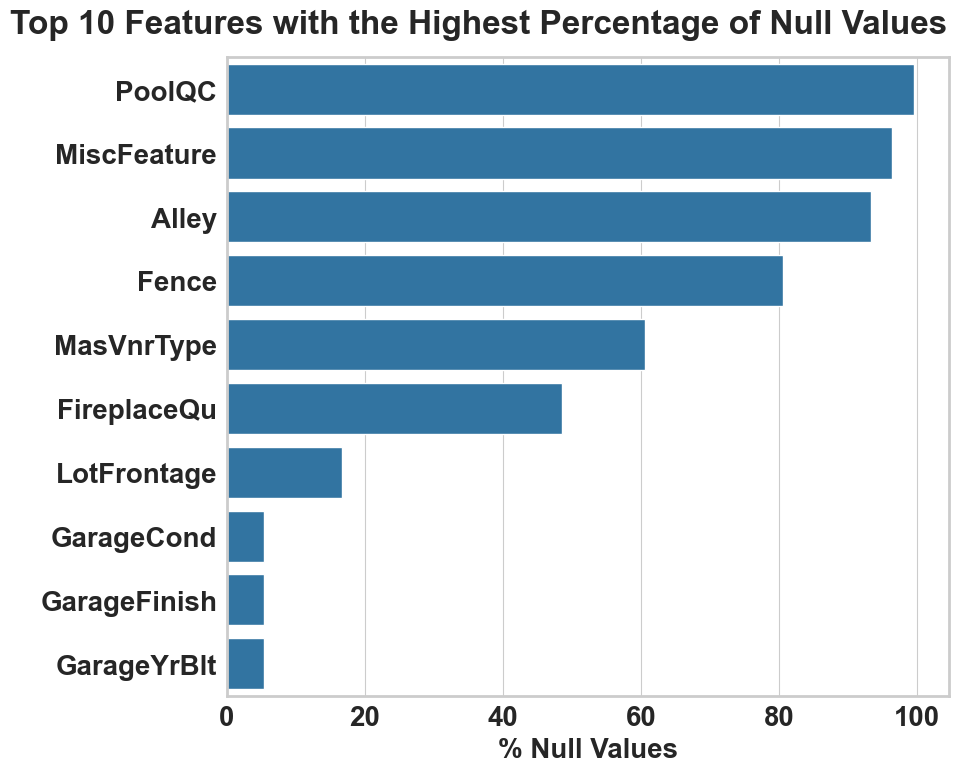

In [211]:
plot_null_counts(data)

## Univariate and Multivariate Feature Relationships

In [212]:
target_name = "SalePrice"
data, y = (
    data.drop(columns = [target_name, 'PID']),
    data[target_name]
)

<Axes: ylabel='Frequency'>

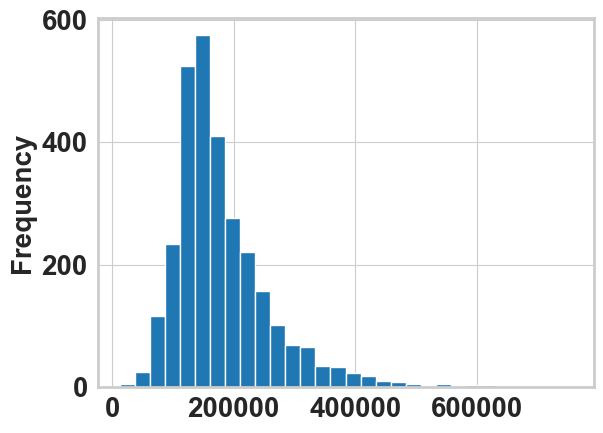

In [213]:
y.plot.hist(bins = 30)

In [214]:
numerical_data = data.select_dtypes(include = "number")
numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2930 non-null   int64  
 1   LotFrontage    2440 non-null   float64
 2   LotArea        2930 non-null   int64  
 3   OverallQual    2930 non-null   int64  
 4   OverallCond    2930 non-null   int64  
 5   YearBuilt      2930 non-null   int64  
 6   YearRemod/Add  2930 non-null   int64  
 7   MasVnrArea     2907 non-null   float64
 8   BsmtFinSF1     2929 non-null   float64
 9   BsmtFinSF2     2929 non-null   float64
 10  BsmtUnfSF      2929 non-null   float64
 11  TotalBsmtSF    2929 non-null   float64
 12  1stFlrSF       2930 non-null   int64  
 13  2ndFlrSF       2930 non-null   int64  
 14  LowQualFinSF   2930 non-null   int64  
 15  GrLivArea      2930 non-null   int64  
 16  BsmtFullBath   2928 non-null   float64
 17  BsmtHalfBath   2928 non-null   float64
 18  FullBath

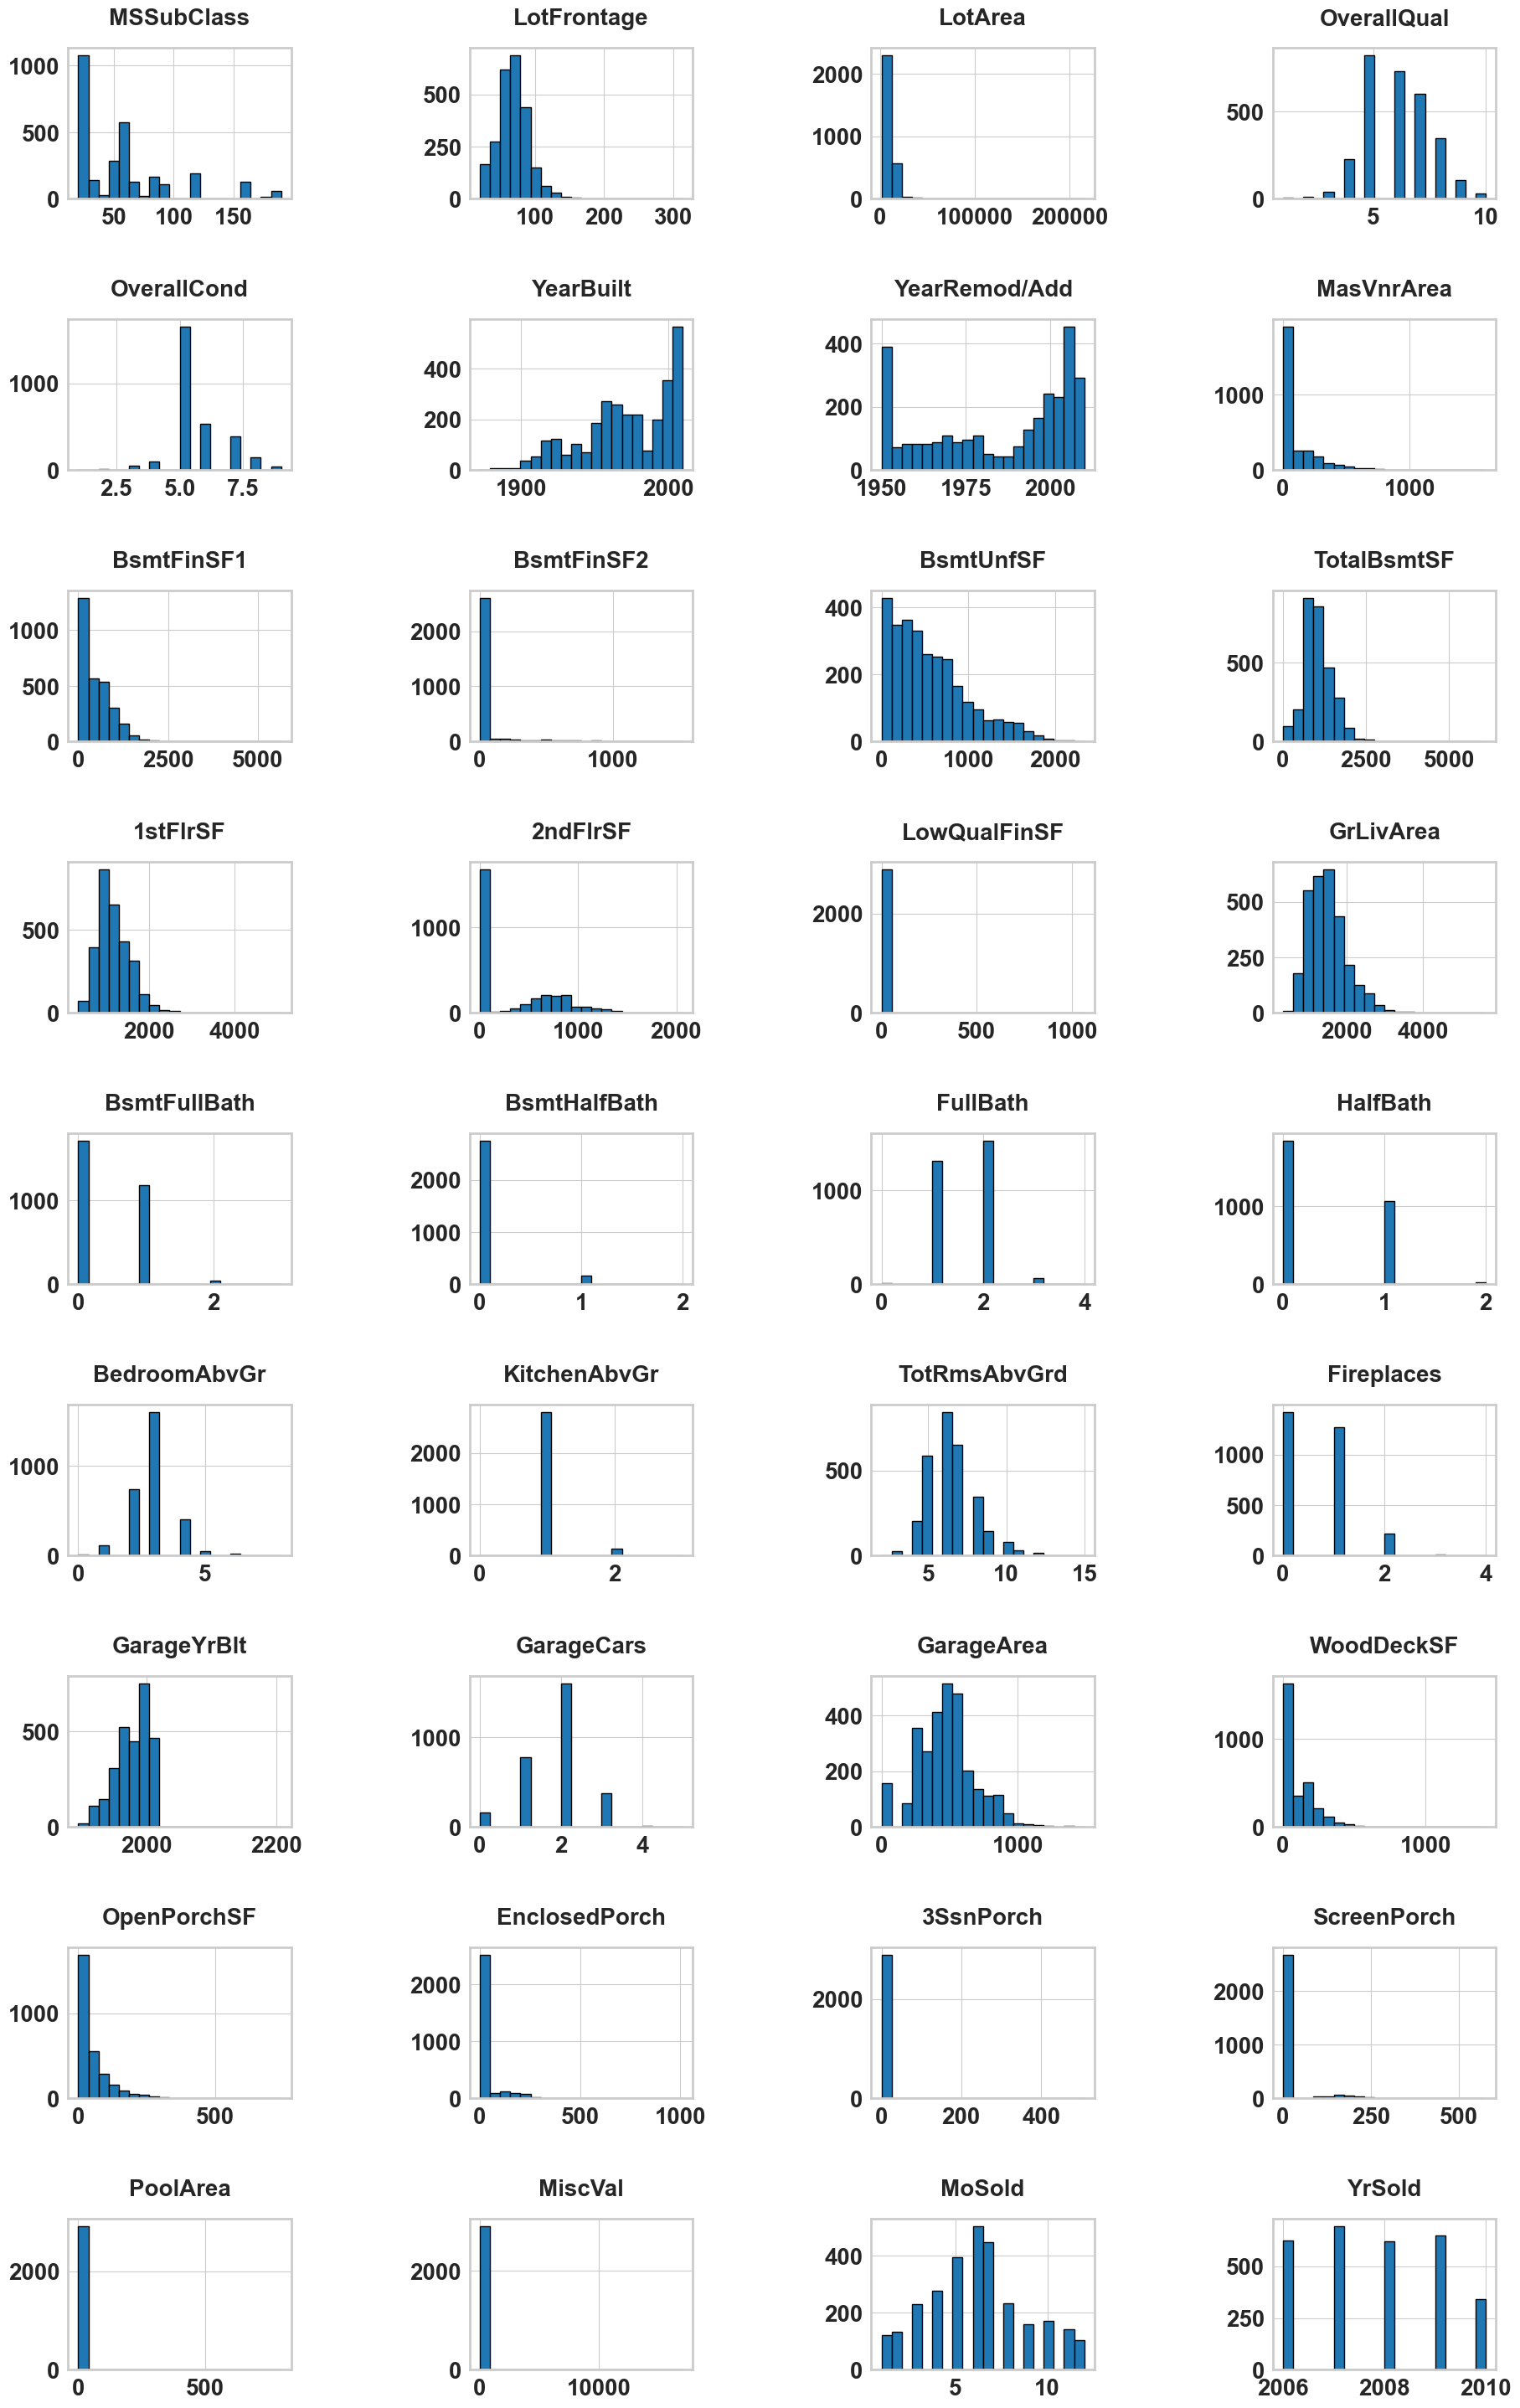

In [215]:
def plot_univariate_numerical_features(df: pd.DataFrame, nrow: int = 9, ncol: int = 4, figsize: tuple = (22, 36), bins: int = 20) -> None:
    """
    Plots histograms for univariate numerical features in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data to be plotted.
    - nrow (int, optional): Number of rows in the subplot grid. Default is 9.
    - ncol (int, optional): Number of columns in the subplot grid. Default is 4.
    - figsize (tuple, optional): Size of the figure. Default is (22, 36).
    - bins (int, optional): Number of bins for the histogram. Default is 20.
    
    Returns:
    - None
    """
    
    numerical_data = df.select_dtypes(include=['number'])
    
    numerical_data.hist(
        bins=bins, figsize=figsize, edgecolor="black", layout=(nrow, ncol)
    )
    plt.subplots_adjust(hspace=0.8, wspace=0.8)

plot_univariate_numerical_features(data)


In [216]:
string_data = data.select_dtypes(object)
string_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2930 non-null   object
 1   Street         2930 non-null   object
 2   Alley          198 non-null    object
 3   LotShape       2930 non-null   object
 4   LandContour    2930 non-null   object
 5   Utilities      2930 non-null   object
 6   LotConfig      2930 non-null   object
 7   LandSlope      2930 non-null   object
 8   Neighborhood   2930 non-null   object
 9   Condition1     2930 non-null   object
 10  Condition2     2930 non-null   object
 11  BldgType       2930 non-null   object
 12  HouseStyle     2930 non-null   object
 13  RoofStyle      2930 non-null   object
 14  RoofMatl       2930 non-null   object
 15  Exterior1st    2930 non-null   object
 16  Exterior2nd    2930 non-null   object
 17  MasVnrType     1155 non-null   object
 18  ExterQual      2930 non-null

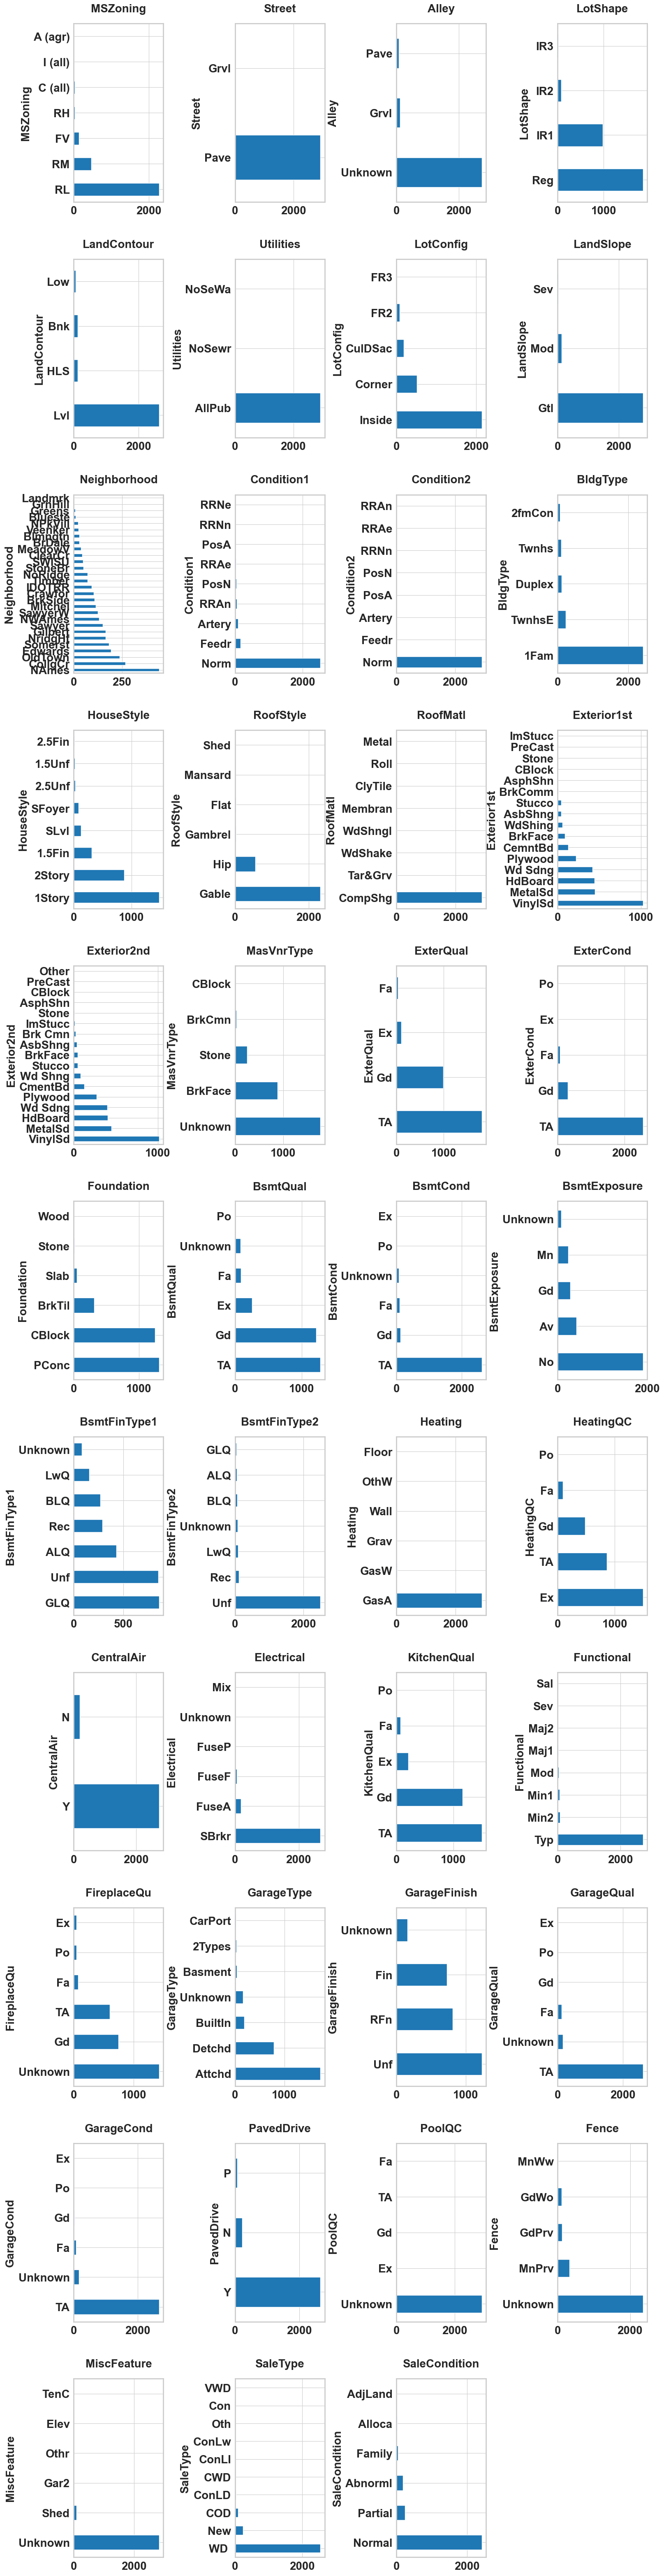

In [217]:
def plot_categorical_features(df: pd.DataFrame, ncol: int = 4, figsize: tuple = (18, 80)) -> None:
    """
    Plots bar charts for categorical features in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data to be plotted.
    - ncol (int, optional): Number of columns in the subplot grid. Default is 4.
    - figsize (tuple, optional): Size of the figure. Default is (18, 80).
    
    Returns:
    - None
    """
    string_data = df.select_dtypes(include=['object']).fillna('Unknown')
    n_string_features = string_data.shape[1]
    nrows = ceil(n_string_features / ncol)
    
    fig, axs = plt.subplots(ncols=ncol, nrows=nrows, figsize=figsize)
    
    for feature_name, ax in zip_longest(string_data, axs.flatten()):
        if feature_name is None:
            # do not show the axis
            ax.axis("off")
            continue
        
        string_data[feature_name].value_counts().plot.barh(ax=ax)
        ax.set_title(feature_name)
    
    plt.subplots_adjust(hspace = 0.32, wspace = 0.8)

# Example usage:
plot_categorical_features(data)

In [218]:
def plot_target_by_cat_features(df: pd.DataFrame, column: str, target: str = 'SalePrice', top_n: int = 10) -> None:
    """
    Visualizes the relationship between a categorical feature and a target variable.

    This function fills missing values in the specified categorical column with 'Unknown' and 
    generates a boxplot and a violin plot to show the distribution and spread of the target variable 
    across different categories of the specified feature. If the number of categories exceeds top_n,
    only the top_n categories are displayed and sorted from high to low based on the median target variable.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    column (str): The name of the categorical column to be plotted.
    target (str, optional): The name of the target variable to be plotted. Default is 'SalePrice'.
    top_n (int, optional): The number of top categories to display. Default is 10.

    Returns:
    None: The function generates plots and does not return any value.

    Notes:
    - The function fills missing values in the specified categorical column with the string 'Unknown' 
    to ensure all data is included in the plots.
    - The color palette used is 'tab20' from the Seaborn library, which provides a variety of colors 
    for distinguishing different categories.
    - The function creates two subplots: a boxplot and a violin plot, providing a comprehensive view of 
    the data distribution and spread.
    """
    # Make a copy of the DataFrame
    data = df.copy()
    
    # Fill missing values in the categorical column with 'Unknown'
    data[column] = data[column].fillna('Unknown')
    
    # Limit to top_n categories based on median target value
    category_medians = data.groupby(column)[target].median().sort_values(ascending=False)
    top_categories = category_medians.index[:top_n]
    data = data[data[column].isin(top_categories)]
    
    # Sort the categorical column by median target value
    data[column] = pd.Categorical(data[column], categories=top_categories, ordered=True)
    
    # Define a color palette
    palette = sns.color_palette('tab20', n_colors=top_n)
    
    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize = (18, 10), sharey = True, sharex = True)
    
    # Plot a boxplot
    sns.boxplot(data=data, x=target, y=column, palette=palette, ax=ax[0])
    ax[0].set_ylabel('')
    ax[0].set_xlabel("Sales Price [USD]")
    
    # Plot a violin plot
    sns.violinplot(data=data, x=target, y=column, hue=column, palette=palette, ax=ax[1])
    ax[1].set_ylabel('')
    ax[1].set_xlabel("Sales Price [USD]")
    
    # Set a common super-title
    plt.suptitle(f'Sales Price of Homes Available by Top {top_n} {column} in Ames City')
    
    # Minimize horizontal space between figures
    plt.subplots_adjust(wspace=0.02, top = 0.95)
    
    # Rotate x-axis labels if needed
    for axes in ax:
        axes.set_xticklabels(axes.get_xticklabels(), rotation= 0, ha = 'right')
    
    # set right and left spines invisible for ax[0] and ax[1]
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)

    # Show the plots
    plt.show()

In [219]:
plot_target_by_cat_features(data, 'Neighborhood')

KeyError: 'Column not found: SalePrice'

<Figure size 1400x800 with 0 Axes>

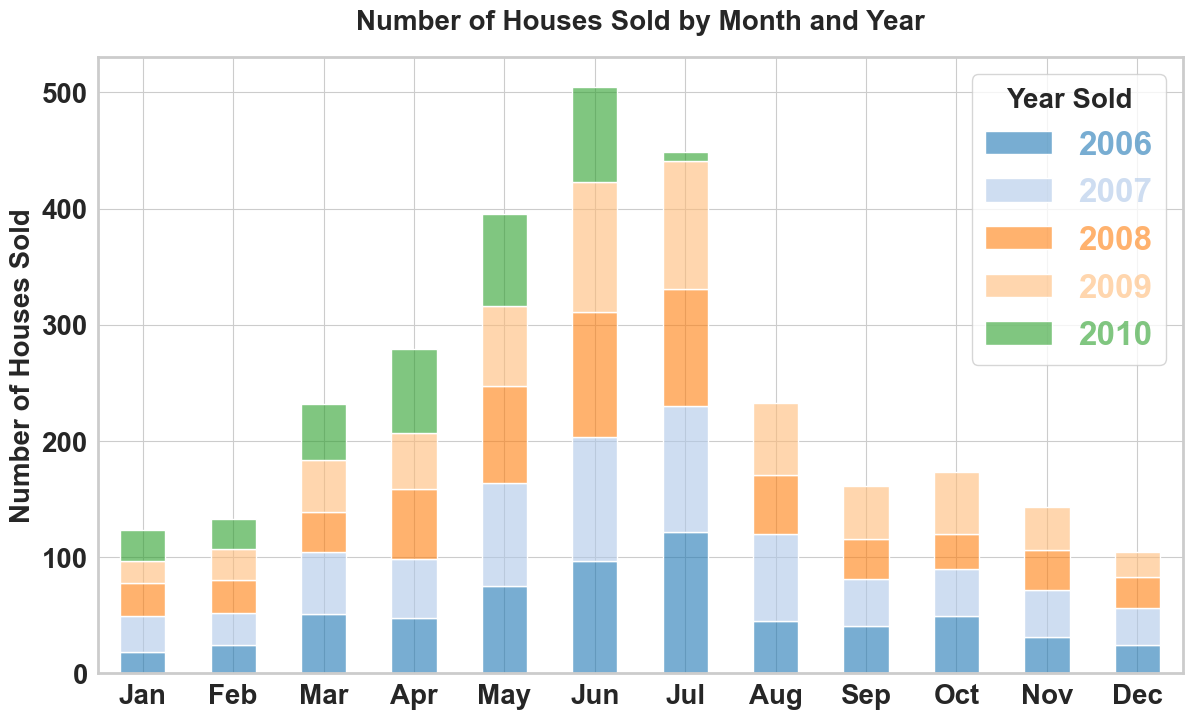

In [165]:
# Group by 'YrSold' and 'MoSold', count and unstack
grouped = data.groupby(['MoSold', 'YrSold']).size().unstack().fillna(0)

# Map month numbers to month names in the columns
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
grouped.index = grouped.index.map(month_names)

# Define a color palette
palette = sns.color_palette('tab20', n_colors = grouped.shape[1])
palette_with_alpha = [(r, g, b, 0.6) for r, g, b in palette]

# Create the plot
plt.figure(figsize=(14, 8))
ax = grouped.plot(kind='bar', stacked=True, figsize=(14, 8), rot = 0, color = palette_with_alpha)

# Set plot title and labels
plt.title('Number of Houses Sold by Month and Year', fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Number of Houses Sold')

# set legend title and color
plt.legend(labelcolor = 'linecolor', title = 'Year Sold')
# Show the plot
plt.show()


In [166]:
def cramers_v(x, y):
    """Calculate Cramér's V for two categorical variables."""
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    minDim = min(confusion_matrix.shape) - 1
    V = np.sqrt((chi2 / n) / minDim)
    return V, p

def filter_strong_associations(df, cramer_threshold = 0.3, p_value_threshold = 0.05):
    """
    Calculate Cramér's V and chi-squared test for each pair of categorical features and 
    return a DataFrame with pairs that have a Cramér's V value greater than cramer_threshold 
    and p-value less than p_value_threshold.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the features.
    cramer_threshold (float, optional): The threshold for Cramér's V value. Default is 0.1.
    p_value_threshold (float, optional): The threshold for p-value. Default is 0.05.
    
    Returns:
    pd.DataFrame: A DataFrame with pairs of columns, Cramér's V values, and p-values.
    """
    categorical_columns = df.select_dtypes(include=['object']).columns
    results = []

    for col1, col2 in combinations(categorical_columns, 2):
        V, p = cramers_v(df[col1].fillna('Unknown'), df[col2].fillna('Unknown'))
        if V > cramer_threshold and p < p_value_threshold:
            results.append({'Column1': col1, 'Column2': col2, 'Cramér\'s V': V, 'p-value': p})
    
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
strong_associations = filter_strong_associations(data)
print(strong_associations)

       Column1        Column2  Cramér's V        p-value
0     MSZoning         Street    0.350307   1.370346e-74
1     MSZoning          Alley    0.419472  3.839313e-213
2     MSZoning      Utilities    0.353416  6.409168e-149
3     MSZoning   Neighborhood    0.543881   0.000000e+00
4        Alley   Neighborhood    0.480565  1.350636e-247
..         ...            ...         ...            ...
73  GarageQual     GarageCond    0.627809   0.000000e+00
74  GarageQual     PavedDrive    0.309125  6.577725e-114
75  GarageCond     PavedDrive    0.330620  3.573558e-131
76      PoolQC    MiscFeature    0.353545  1.328319e-298
77    SaleType  SaleCondition    0.472634   0.000000e+00

[78 rows x 4 columns]


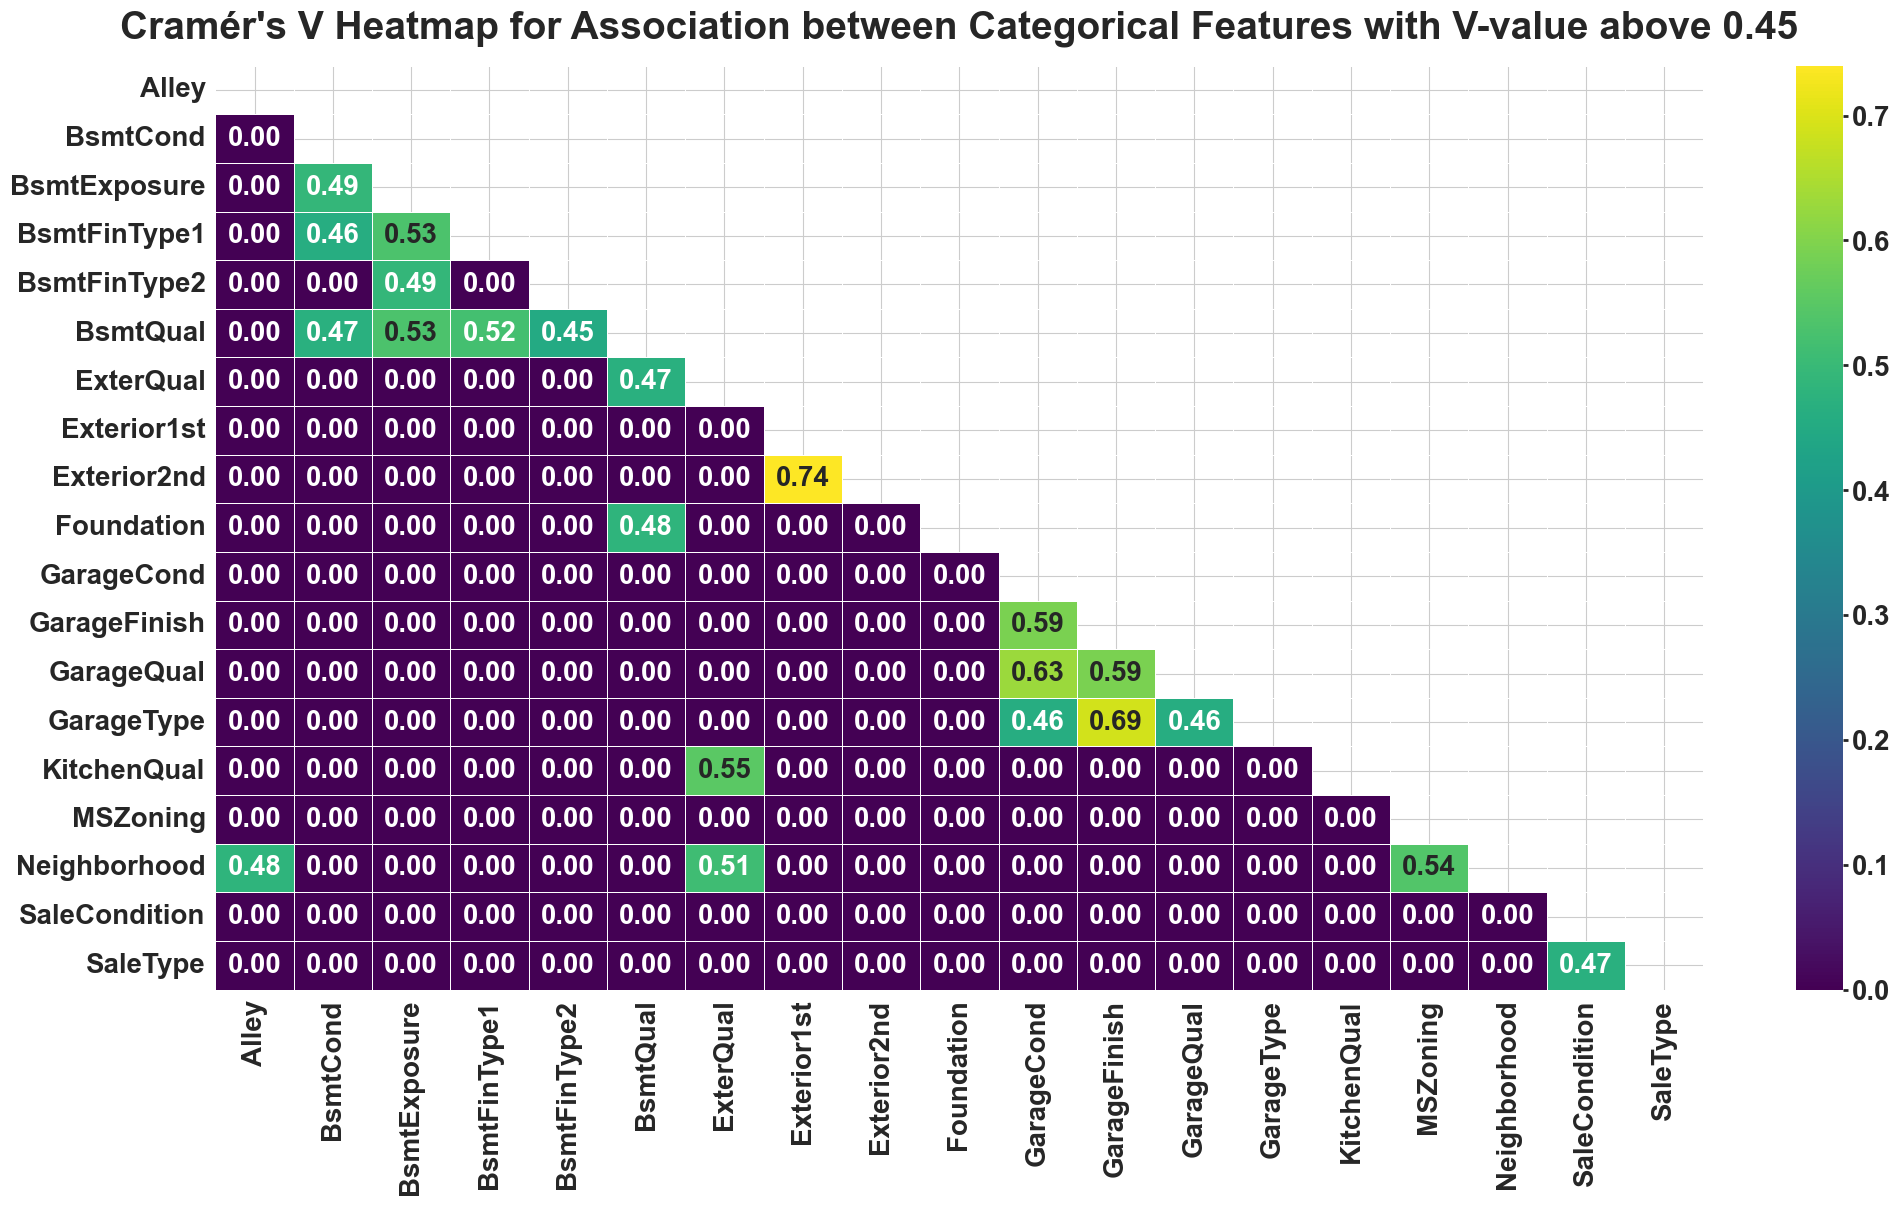

In [167]:
def calculate_cramers_v_matrix(df, cramer_v_threshold = 0.3):
    """
    Calculate the Cramér's V matrix for all pairs of categorical features.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the features.
    cramer_v_threshold (float, optional): The threshold for filtering Cramér's V values.
    
    Returns:
    pd.DataFrame: A DataFrame with Cramér's V values for each pair of categorical features that pass the threshold.
    """
    categorical_columns = df.select_dtypes(include=['object']).columns
    cramers_v_dict = defaultdict(dict)

    for col1, col2 in combinations(categorical_columns, 2):
        V, _ = cramers_v(df[col1].fillna('Unknown'), df[col2].fillna('Unknown'))
        if V >= cramer_v_threshold:
            cramers_v_dict[col1][col2] = round(V, 2)
            cramers_v_dict[col2][col1] = round(V, 2)  # Mirror the value across the diagonal

    # Convert defaultdict to DataFrame
    cramers_v_matrix = pd.DataFrame(cramers_v_dict).fillna(0)  # Fill missing values with 0

    # Ensure the order of columns and index are the same
    cramers_v_matrix = cramers_v_matrix.reindex(sorted(cramers_v_matrix.columns), axis=0)
    cramers_v_matrix = cramers_v_matrix.reindex(sorted(cramers_v_matrix.columns), axis=1)
    
    # Create mask for the upper triangle
    mask = np.triu(np.ones_like(cramers_v_matrix, dtype=bool))

    return cramers_v_matrix.astype(float), mask  # Ensure all values are float and return mask

# Example usage
cramer_v_threshold = 0.45
cramers_v_matrix, mask = calculate_cramers_v_matrix(data, cramer_v_threshold = cramer_v_threshold)

# Plot the heatmap
plt.figure(figsize = (24, 12))
sns.heatmap(cramers_v_matrix, annot = True, cmap = 'viridis', linewidths = .5, fmt='.2f', mask=mask)
plt.title(f"Cramér's V Heatmap for Association between Categorical Features with V-value above {cramer_v_threshold}", fontsize = 28)
plt.show()

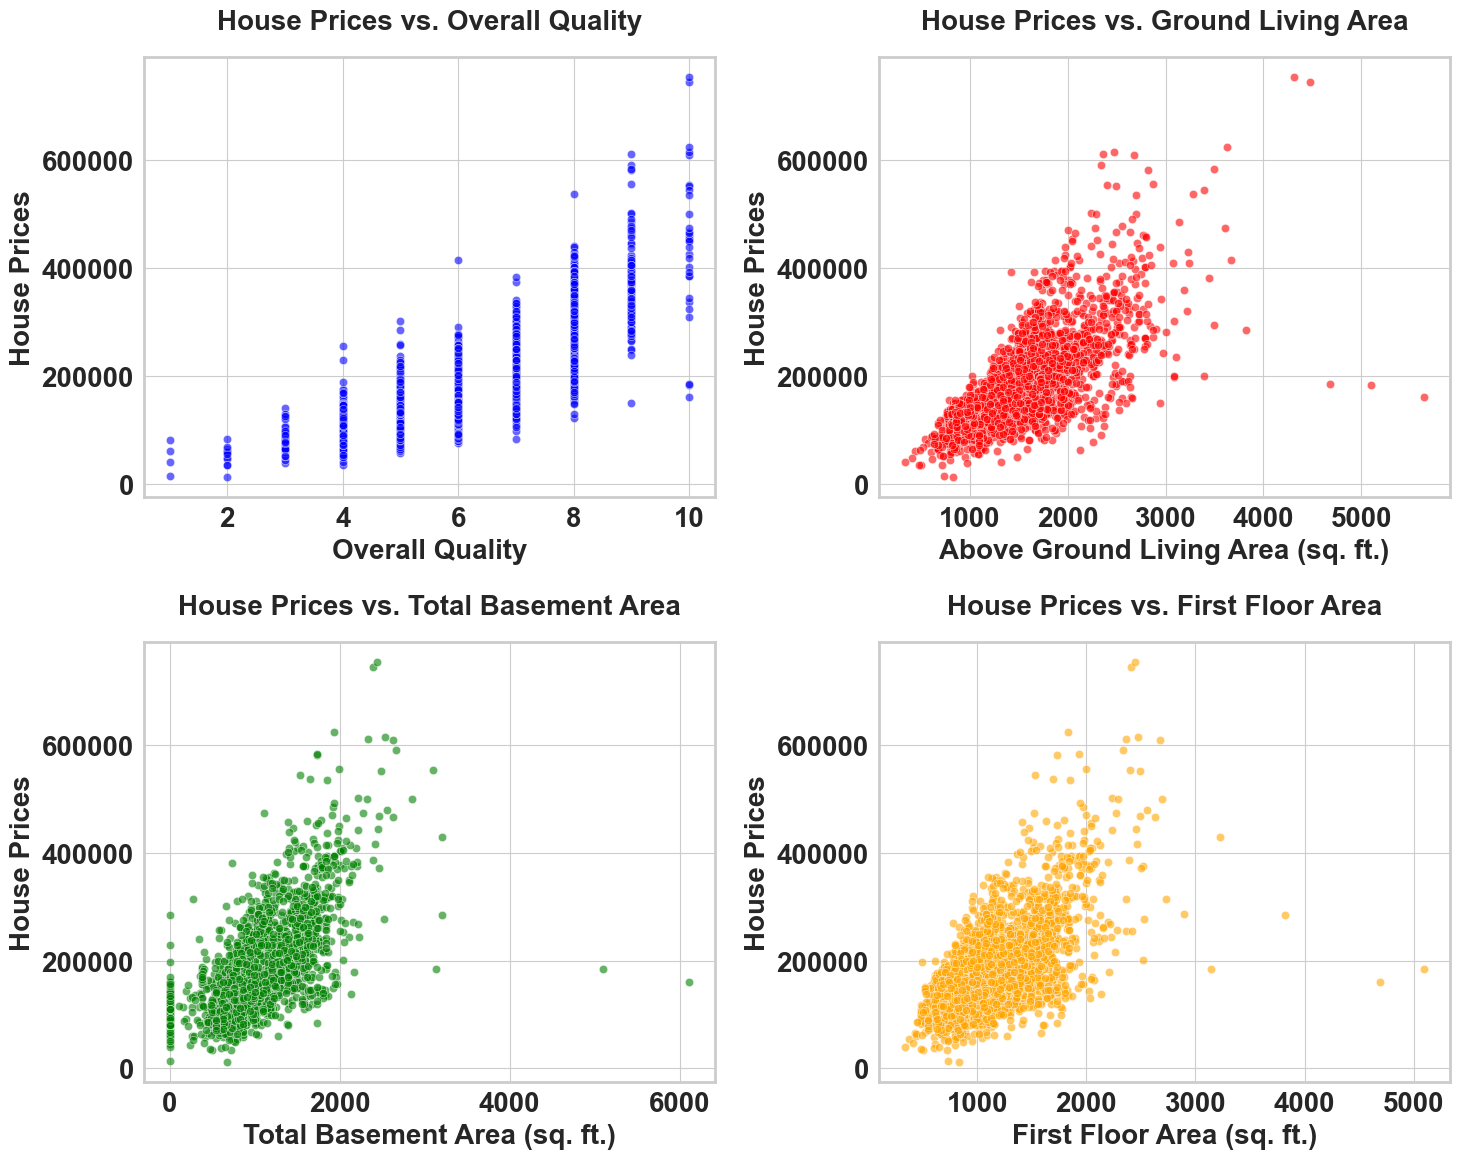

In [168]:
# Setting up the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

palette = ['blue', 'red', 'green', 'orange']
# Scatter plot for SalePrice vs. OverallQual
sns.scatterplot(x=data['OverallQual'], y= y, ax=ax[0, 0], color= palette[0], alpha=0.6)
ax[0, 0].set_title('House Prices vs. Overall Quality')
ax[0, 0].set_ylabel('House Prices')
ax[0, 0].set_xlabel('Overall Quality')
 
# Scatter plot for SalePrice vs. GrLivArea
sns.scatterplot(x=data['GrLivArea'], y= y, ax=ax[0, 1], color = palette[1], alpha=0.6)
ax[0, 1].set_title('House Prices vs. Ground Living Area')
ax[0, 1].set_ylabel('House Prices')
ax[0, 1].set_xlabel('Above Ground Living Area (sq. ft.)')
 
# Scatter plot for SalePrice vs. TotalBsmtSF
sns.scatterplot(x=data['TotalBsmtSF'], y= y, ax=ax[1, 0], color= palette[2], alpha=0.6)
ax[1, 0].set_title('House Prices vs. Total Basement Area')
ax[1, 0].set_ylabel('House Prices')
ax[1, 0].set_xlabel('Total Basement Area (sq. ft.)')
 
# Scatter plot for SalePrice vs. 1stFlrSF
sns.scatterplot(x=data['1stFlrSF'], y= y, ax=ax[1, 1], color= palette[3], alpha=0.6)
ax[1, 1].set_title('House Prices vs. First Floor Area')
ax[1, 1].set_ylabel('House Prices')
ax[1, 1].set_xlabel('First Floor Area (sq. ft.)')
 
# Adjust layout
plt.tight_layout()
plt.show()

## Data Preprocessing

Lets look percentage of possible outliers for contamination factor IsolationForest (the default is auto as defined by original research paper).

In [169]:
def calculate_outlier_percentage(df: pd.DataFrame, lower_percentile: float = 1, upper_percentile: float = 99) -> pd.DataFrame:
    """
    Calculates the percentage of outliers based on winsorization for all numerical variables in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    lower_percentile (float, optional): The lower percentile for winsorization. Default is 5.
    upper_percentile (float, optional): The upper percentile for winsorization. Default is 95.

    Returns:
    pd.DataFrame: A DataFrame containing the column names and the percentage of outliers.
    """
    outlier_percentages = {}

    numerical_cols = df.select_dtypes(include=[np.number]).columns

    for col in numerical_cols:
        x_low, x_high = np.percentile(df[col].dropna(), [lower_percentile, upper_percentile])
        total_values = len(df[col])
        outliers = len(df[~df[col].between(x_low, x_high)])
        outlier_percentage = round((outliers / total_values) * 100, 2)
        outlier_percentages[col] = outlier_percentage

    outlier_df = pd.DataFrame(list(outlier_percentages.items()), columns=['Numerical Features', 'Outliers Percentage'])
    return outlier_df

# Example usage
outlier_percentages = calculate_outlier_percentage(data)
print(outlier_percentages.sort_values(by = 'Outliers Percentage', ascending = False).reset_index(drop = True))

   Numerical Features  Outliers Percentage
0         LotFrontage                17.58
1         GarageYrBlt                 6.38
2           GrLivArea                 2.05
3            1stFlrSF                 2.01
4           YearBuilt                 1.84
5          MasVnrArea                 1.81
6             LotArea                 1.67
7        TotRmsAbvGrd                 1.57
8          BsmtFinSF1                 1.06
9          BsmtFinSF2                 1.06
10          BsmtUnfSF                 1.06
11        TotalBsmtSF                 1.06
12         GarageArea                 1.06
13        OpenPorchSF                 1.02
14            MiscVal                 1.02
15         WoodDeckSF                 1.02
16       BedroomAbvGr                 1.02
17           2ndFlrSF                 1.02
18       LowQualFinSF                 1.02
19        ScreenPorch                 1.02
20          3SsnPorch                 0.99
21      EnclosedPorch                 0.96
22         

### Automated Pipelines
Although Scikit learn comes loaded with a set of standard transformers, we will begin with a custom one to understand what they do and how they work. The first thing to remember is that a custom transformer is an estimator and a transformer, so we will create a class that inherits from both BaseEstimator and TransformerMixin. It is a good practice to initialize it with super().__init__(). By inheriting, we get a standard method such as get_params and set_params for free. In the init, we also want to create the model parameter or parameters we want to learn.

<a href = "https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-ef792bbb3260">ref1</a>

<a href = "https://stackoverflow.com/questions/64900801/implementing-knn-imputation-on-categorical-variables-in-an-sklearn-pipeline">ref2</a>

<a href = "https://www.superannotate.com/blog/how-to-optimize-machine-learning-pipeline#:~:text=A%20machine%20learning%20pipeline%20otherwise,a%20fully%2Dfunctioning%20ML%20pipeline.">Automated Pipeline</a>



In [89]:
def fill_missing_values(df, cat_threshold = 0.5):
    """
    Fills missing values in a DataFrame for both categorical and numerical columns based on specific rules.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame with missing values.
    cat_threshold : float, optional (default = 0.5 percentage)
        The threshold for handling missing values in categorical columns.
        - If the percentage of missing values in a categorical column is less than `cat_threshold`, 
        fill with the most frequent value.
        - If it exceeds the threshold, fill with the category 'Unknown'.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with no missing values.
        
    Rules for filling missing values:
    1. Categorical columns:
        - If missing values are less than `cat_threshold`, fill with the most frequent category.
        - If greater than the threshold, fill with 'Unknown'.
    2. LotFrontage and GarageYrBlt columns:
        - Fill using groupby medians based on relevant related columns.
    3. Other numeric columns:
        - Fill missing values with the overall median of the column.
    """

    # Make a copy of the original DataFrame
    data = df.copy()

    # Handle missing values in categorical columns
    for col in data.select_dtypes(include=['object', 'category']).columns:
        missing_ratio = data[col].isnull().mean() * 100.
        if missing_ratio > cat_threshold:
            data[col] = data[col].fillna('Unknown')
        else:
            data[col] = data[col].fillna(data[col].mode()[0])

    # Handle LotFrontage with groupby median imputation
    if 'LotFrontage' in data.columns:
        data['LotFrontage'] = data.groupby(['HouseStyle', 'Neighborhood', 'BldgType', 
        'LandContour', 'LotConfig'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # Handle GarageYrBlt with groupby median imputation
    if 'GarageYrBlt' in data.columns:
        data['GarageYrBlt'] = data.groupby(['YearBuilt', 'GarageType', 'Neighborhood'])['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

    # Handle other numeric columns with median imputation
    for col in data.select_dtypes(include=['number']).columns:
        if data[col].isnull().sum() > 0:
            data[col] = data[col].fillna(data[col].median())

    return data


In [137]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.means_ = None
        self.std_ = None

    def fit(self, X, y=None):
        X = X.to_numpy()
        self.means_ = X.mean(axis=0, keepdims=True)
        self.std_ = X.std(axis=0, keepdims=True)

        return self

    def transform(self, X, y=None):
        X[:] = (X.to_numpy() - self.means_) / self.std_

        return X

In [91]:
data.columns

Index(['PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDri

### Feature Engineering

In [220]:
# Create new features
data['TotalSqFt'] = data['GrLivArea'] + data['TotalBsmtSF']
data['YrRemodAge'] = data['YrSold'] - data['YearRemod/Add']
data['HouseAge'] = 2010 - data['YearBuilt']
data['GarageAge'] = 2010 - data['GarageYrBlt']
data['TotalBaths'] = data['FullBath'] + 0.5 * data['HalfBath'] + data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath']

### Split the data set into train and test set

In [221]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 42)

In [222]:
X_train = fill_missing_values(X_train)

### Feature Selection

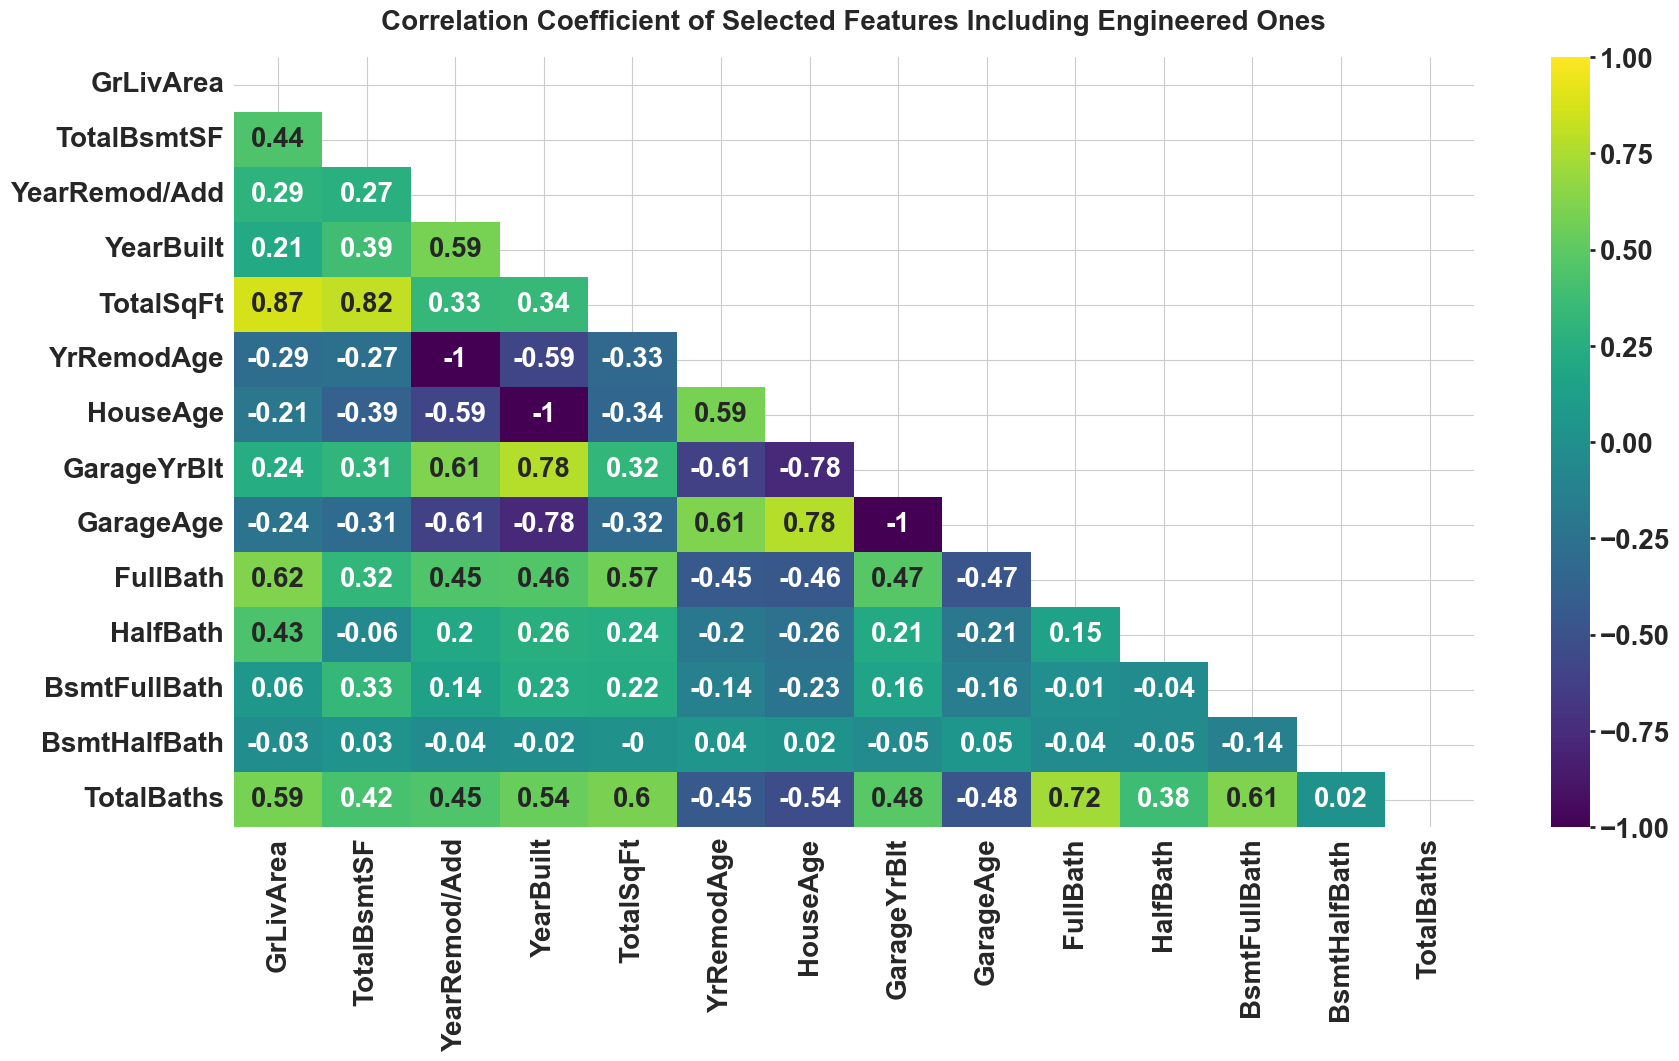

In [173]:
# Select old and new features
selected_features = ['GrLivArea', 'TotalBsmtSF', 'YearRemod/Add', 'YearBuilt', 'TotalSqFt', 'YrRemodAge', 'HouseAge',
                     'GarageYrBlt', 'GarageAge', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBaths']

# Compute the correlations for the selected features
corr_matrix = X_train[selected_features].corr().round(2)

# Generate a mask to only show the bottom triangle
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

# Generate the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot = True, mask = mask, vmin = -1, vmax = 1, cmap = 'viridis')
plt.title('Correlation Coefficient of Selected Features Including Engineered Ones')
plt.show()

## Top-n Categorical Features

In [233]:
data = X_train.drop(columns = ['GrLivArea', 'TotalBsmtSF', 'YearRemod/Add', 'YearBuilt', 'GarageYrBlt', 
                            'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])
X_test_new = X_test.drop(columns = ['GrLivArea', 'TotalBsmtSF', 'YearRemod/Add', 'YearBuilt', 'GarageYrBlt', 
                            'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])

In [175]:
def anova_tests(df: pd.DataFrame, target: Union[str, pd.Series]) -> pd.DataFrame:
    """
    Perform ANOVA tests to assess the relationship between categorical inputs and a numerical target.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    target (str or pd.Series): The name of the numerical target column or a standalone Series.

    Returns:
    pd.DataFrame: A DataFrame with the ANOVA F-values and p-values for each categorical column.
    """
    # Check if target is a string (column name) or a standalone Series
    if isinstance(target, str):
        # Ensure the target column is in the DataFrame
        if target not in df.columns:
            raise ValueError("Target column not found in DataFrame")
        target_data = df[target]
    else:
        # If the target is provided as a Series
        target_data = target
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Store results
    results = []

    for cat_col in categorical_columns:
        # Group the numerical data by the categorical column
        groups = [target_data[df[cat_col] == category] for category in df[cat_col].unique()]
        
        # Perform ANOVA
        f_value, p_value = stats.f_oneway(*groups)
        
        # Append results
        results.append({'Categorical Column': cat_col, 'F-value': f_value, \
        'P-value': p_value})
    return pd.DataFrame(results).sort_values(by = ['F-value', 'P-value'], 
            ascending = False).reset_index(drop = True)

In [176]:
anova_tests(data, y_train)

,Categorical Column,F-value,P-value
0,ExterQual,736.365436,0.000000e+00
1,KitchenQual,672.454143,3.239848e-315
2,BsmtQual,453.760570,0.000000e+00
3,GarageFinish,320.150197,3.723546e-174
4,FireplaceQu,204.513701,3.218798e-181
5,CentralAir,183.137224,3.126434e-40
6,Foundation,174.396667,5.114029e-158
7,HeatingQC,151.375728,2.845975e-115
8,GarageType,122.352003,9.276168e-135
9,BsmtExposure,119.692946,5.204699e-93


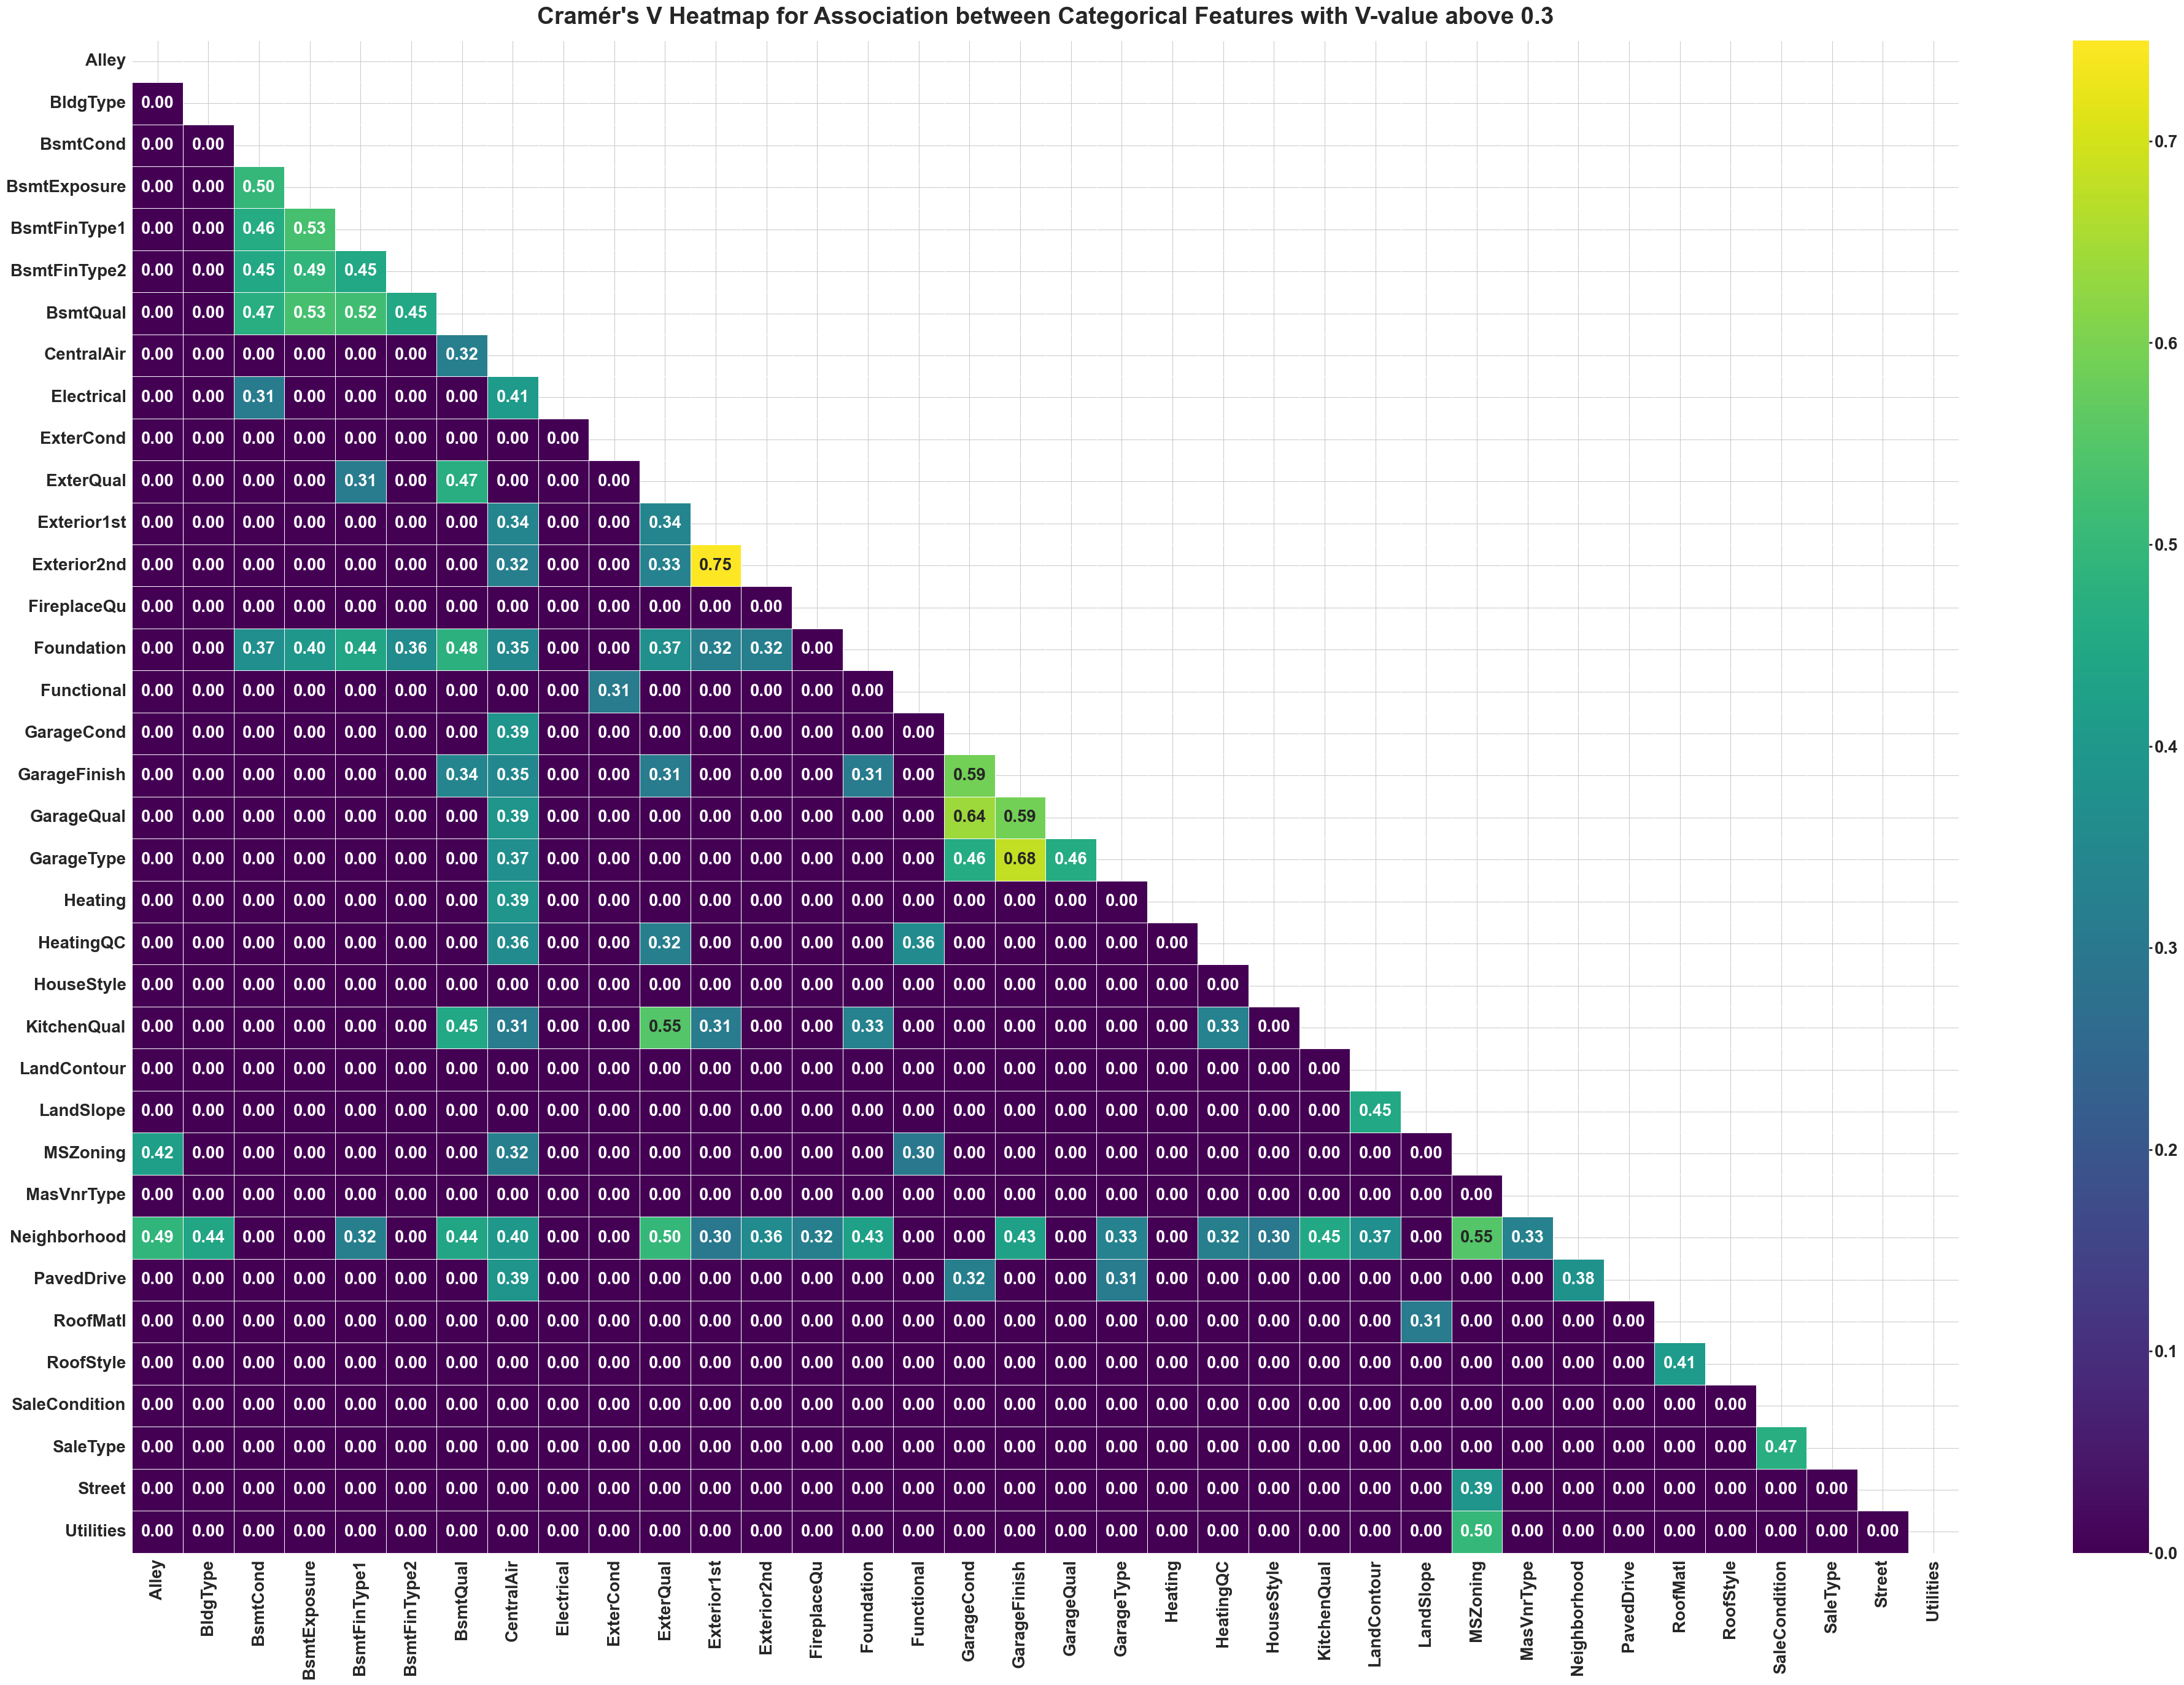

In [177]:
# Example usage
cramer_v_threshold = 0.30
cramers_v_matrix, mask = calculate_cramers_v_matrix(data, cramer_v_threshold = cramer_v_threshold)

# Plot the heatmap
plt.figure(figsize = (48, 32))
sns.heatmap(cramers_v_matrix, annot = True, cmap = 'viridis', linewidths = .5, fmt='.2f', mask=mask)
plt.title(f"Cramér's V Heatmap for Association between Categorical Features with V-value above {cramer_v_threshold}", fontsize = 28)
plt.show()

## Categorical Feature Importance in Predicting Sale Price

When examining the importance of features in predicting **Sale Price**, we analyze the **ANOVA F-values** and **p-values**.


### F-value:
- A higher F-value indicates significant differences in group means (based on categorical features), suggesting that the feature greatly influences the target variable (Sale Price).

### p-value:
- A p-value below **0.05** signifies statistical significance. Smaller p-values provide stronger evidence against the null hypothesis (which posits that the group means are equal), indicating that the feature has a notable effect on Sale Price.

## Results Summary:

| **Categorical Column** | **F-value** | **p-value** |
|------------------------|-------------|-------------|
| ExterQual              | 809.62      | 0.000000e+00 |
| GarageCars             | 412.91      | 0.000000e+00 |
| KitchenQual            | 543.67      | 0.000000e+00 |
| Neighborhood           | 120.20      | 0.000000e+00 |
| BsmtQual               | 477.84      | 0.000000e+00 |

### Highly Significant Features:
- **ExterQual (F-value: 809.62, p-value: 0.0)**: Extremely strong relationship with Sale Price.
- **GarageCars (F-value: 412.91, p-value: 0.0)**: Significant impact.
- **KitchenQual (F-value: 543.67, p-value: 0.0)**: Notable influence.
- **Neighborhood (F-value: 120.20, p-value: 0.0)**: Affects Sale Price significantly.
- **BsmtQual (F-value: 477.84, p-value: 0.0)**: Highly significant as well.

### Less Significant Features:
- **Utilities (F-value: 2.995, p-value: 0.08)**: Indicates lower significance.
- **BsmtHalfBath (F-value: 1.142, p-value: 0.33)**: Not statistically significant.
- **BsmtFinSF2 (F-value: 0.737, p-value: 0.999)**: Not significant.

## Next Steps:

1. **Prioritize Significant Features**:
   - Focus on impactful features like **ExterQual**, **GarageCars**, and **KitchenQual** for your predictive models, as they strongly influence Sale Price.

2. **Review Less Significant Features**:
   - Consider dropping or transforming features like **BsmtFinSF2** and **BsmtHalfBath**, as they contribute minimally to Sale Price predictions.

3. **Analyze Cramér's V Value**:
   - To avoid having strongly associated features, examine Cramér's V value, which measures the association between categorical variables. This step helps in selecting features that are not overly correlated, improving model performance and interpretability.

Lets drop categorical features that has strong association with other categorical features and select top 4 categorical features that people usually look for. Neighborhood, Fireplace Quality, Kitchen Quality, Basement Exposure.


## Selecting Top-n Numerical Features

### Use r_regression and f_regression from sklearn
<a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.html'> r_regression</a>
Compute Pearson’s r for each features and the target.

Pearson’s r is also known as the Pearson correlation coefficient.

Linear model for testing the individual effect of each of many regressors. This is a scoring function to be used in a feature selection procedure, not a free standing feature selection procedure.

The cross correlation between each regressor and the target is computed as:
E[(X[:, i] - mean(X[:, i])) * (y - mean(y))] / (std(X[:, i]) * std(y))

### Feature Selection: f_regression vs r_regression

Both `f_regression` and `r_regression` are used for feature selection based on linear relationships between features and the target variable.

- **f_regression** is preferred because it provides F-scores and p-values to assess feature significance, independent of positive or negative associations.
- **r_regression** computes Pearson correlation, returning values between -1 and 1, but lacks p-values, making it less useful for assessing statistical significance.

For downstream classifiers, **f_regression** is typically favored for its statistical rigor.

In [178]:
from sklearn.feature_selection import r_regression, f_regression

# Compute r_regression scores
# scores = f_regression(data_new.select_dtypes(include='number'), target)

# Compute f_regression scores
f_score, p_value = f_regression(data.select_dtypes(include='number'), y_train)

# Create a DataFrame with scores
scores_df = pd.DataFrame({
    'Feature': data.select_dtypes(include='number').columns,
    'F-Score': f_score,
    'P-Value': p_value
}).sort_values(by = ['F-Score', 'P-Value'], ascending=False).reset_index(drop = True)

# Select top features
top_features = scores_df.head(35)

# Sort top_features by the absolute value of 'Score'
print(top_features)



          Feature      F-Score        P-Value
0     OverallQual  4030.762673   0.000000e+00
1       TotalSqFt  3511.813072   0.000000e+00
2      GarageCars  1661.535113  5.401955e-275
3      TotalBaths  1613.790893  6.879371e-269
4      GarageArea  1566.511083  9.043226e-263
5        1stFlrSF  1369.423612  1.939001e-236
6        HouseAge   991.671383  8.387002e-182
7      YrRemodAge   868.419479  1.267421e-162
8       GarageAge   778.032522  4.405989e-148
9      MasVnrArea   717.070657  4.925451e-138
10   TotRmsAbvGrd   684.065511  1.648497e-132
11     Fireplaces   655.021473  1.346129e-127
12     BsmtFinSF1   512.830777  7.774940e-103
13     WoodDeckSF   292.181400   8.003561e-62
14    LotFrontage   260.781788   1.056003e-55
15    OpenPorchSF   227.782028   3.460194e-49
16       2ndFlrSF   197.657484   3.663641e-43
17        LotArea   171.675782   6.629992e-38
18      BsmtUnfSF    64.430720   1.565991e-15
19   BedroomAbvGr    53.371996   3.765759e-13
20    ScreenPorch    44.755253   2

### Feature Selection Based on F-Score and P-Value

Based on the F-scores and p-values, the following conclusions can be drawn:

#### Features to Keep:
- **TotalSqFt**, **OverallQual**, **1stFlrSF**, **TotalBaths**, **GarageCars**, **GarageArea**, **HouseAge**, etc.
  - These features have high F-scores and very low p-values (statistically significant), indicating they are important predictors.

#### Features to Drop:
- **3SsnPorch**, **PoolArea**, **LowQualFinSF**, **BsmtFinSF2**, **MiscVal**, **MoSold**, **YrSold**
  - These features have low F-scores and high p-values (statistically insignificant), suggesting they have weak relationships with the target variable.


In [179]:
# compute the vif for all given features
def compute_vif(df):
    
    d = df.select_dtypes(include = 'number')
    # the calculation of variance inflation requires a constant
    d['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = d.columns
    vif["VIF"] = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif
# Criterion: Remove variables with VIF >= 5.0

In [180]:
compute_vif(data).sort_values(by = 'VIF', ascending = False).reset_index(drop = True)

,Variable,VIF
0,TotalSqFt,2980.062541
1,BsmtFinSF1,957.601977
2,BsmtUnfSF,882.734802
3,2ndFlrSF,856.740562
4,1stFlrSF,697.474231
5,BsmtFinSF2,136.687850
6,LowQualFinSF,10.265053
7,GarageCars,5.578599
8,GarageArea,5.443760
9,TotRmsAbvGrd,4.479966


From the VIF values, TotalSqFt, BsmtFinSF1, BsmtUnfSF, 2ndFlrSF, and 1stFlrSF have extremely high VIF scores, indicating severe multicollinearity. These features are likely highly correlated with each other, making them problematic for regression analysis. We might want to keep only TotalSqFt and remove other area related features BsmtFinSF1, BsmtUnfSF, 2ndFlrSF, and 1stFlrSF as they have lower F-Score and P-values that might reduce VIF score.

To address this, we may consider removing some of these features or combining them to reduce redundancy. Features with lower VIF values, such as GarageCars, GarageArea, and TotRmsAbvGrd, are less likely to suffer from multicollinearity.

In [181]:
compute_vif(data.drop(columns = ['BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF', '1stFlrSF', 'GarageArea',
        "2ndFlrSF", "BsmtUnfSF", "BedroomAbvGr", "EnclosedPorch", "ScreenPorch", 
    "KitchenAbvGr", "OverallCond", "MSSubClass", "3SsnPorch", "PoolArea", 
    "LowQualFinSF", "BsmtFinSF2", "MiscVal", "MoSold", "YrSold"])).\
sort_values(by = 'VIF', ascending = False).reset_index(drop = True)

,Variable,VIF
0,TotalSqFt,3.536970
1,HouseAge,3.389633
2,GarageAge,2.955172
3,OverallQual,2.711003
4,TotalBaths,2.097282
5,TotRmsAbvGrd,1.958635
6,YrRemodAge,1.909756
7,GarageCars,1.893344
8,Fireplaces,1.401744
9,MasVnrArea,1.357075


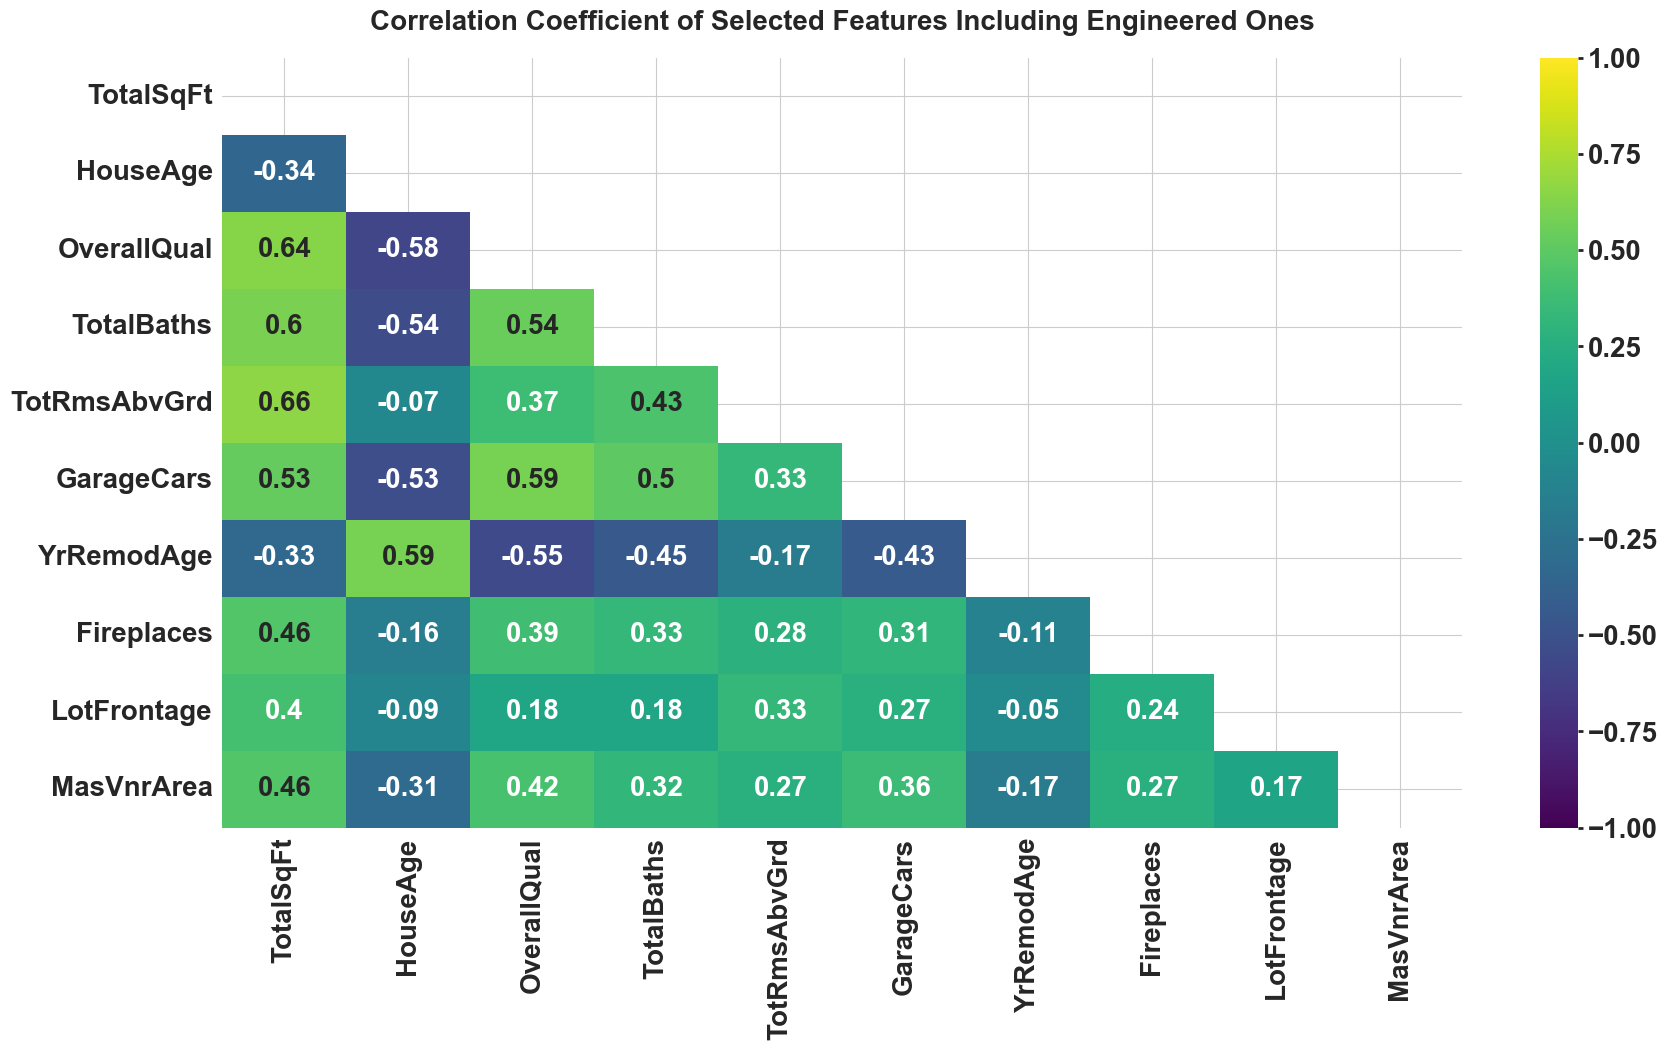

In [182]:
# Select old and new features
selected_features = [
    "TotalSqFt", "HouseAge", "OverallQual", "TotalBaths", 
    "TotRmsAbvGrd", "GarageCars", "YrRemodAge", "Fireplaces",
    "LotFrontage", "MasVnrArea"]


# Compute the correlations for the selected features
corr_matrix = data[selected_features].corr().round(2)

# Generate a mask to only show the bottom triangle
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

# Generate the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot = True, mask = mask, vmin = -1, vmax = 1, cmap = 'viridis')
plt.title('Correlation Coefficient of Selected Features Including Engineered Ones')
plt.show()

In [183]:
compute_vif(data[selected_features])

,Variable,VIF
0,TotalSqFt,3.367572
1,HouseAge,2.283658
2,OverallQual,2.657610
3,TotalBaths,2.065626
4,TotRmsAbvGrd,1.949337
5,GarageCars,1.872338
6,YrRemodAge,1.795730
7,Fireplaces,1.345782
8,LotFrontage,1.252839
9,MasVnrArea,1.354716


# Model Building

https://machinelearningmastery.com/from-features-to-performance-crafting-robust-predictive-models/

## Base Model: CatBoost with all features
Why CatBoost is good?

<img src="https://i.sstatic.net/Fmqc7.png" alt="Image Description" width="500" height="600">

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


In [187]:
# Identify and fill NaNs in categorical columns
cat_features = [col for col in data.columns if data[col].dtype == 'object']
# Define and train the default CatBoost Model
base_model = CatBoostRegressor(cat_features = cat_features, random_state = 42, verbose = 0)
base_scores = cross_val_score(base_model, data, y_train, cv = 5, scoring = 'r2')
print(f"Average r2 score for default CatBoost: {base_scores.mean():.4f}")

Average r2 score for default CatBoost: 0.9125


In [185]:
base_scores

array([0.88449204, 0.92523497, 0.92133909, 0.89634955, 0.93528412])

In [188]:
# CatBoost with Ordered Boosting
base_model_ordered = CatBoostRegressor(cat_features = cat_features, random_state = 42, verbose = 0, boosting_type='Ordered')
base_scores_ordered = cross_val_score(base_model_ordered, data, y_train, cv = 5, scoring = 'r2')
print(f"Average r2 score for default CatBoost: {base_scores_ordered.mean():.4f}")

Average r2 score for default CatBoost: 0.9076


Ordered Boosting is novel and should have performed better but not in our data set.

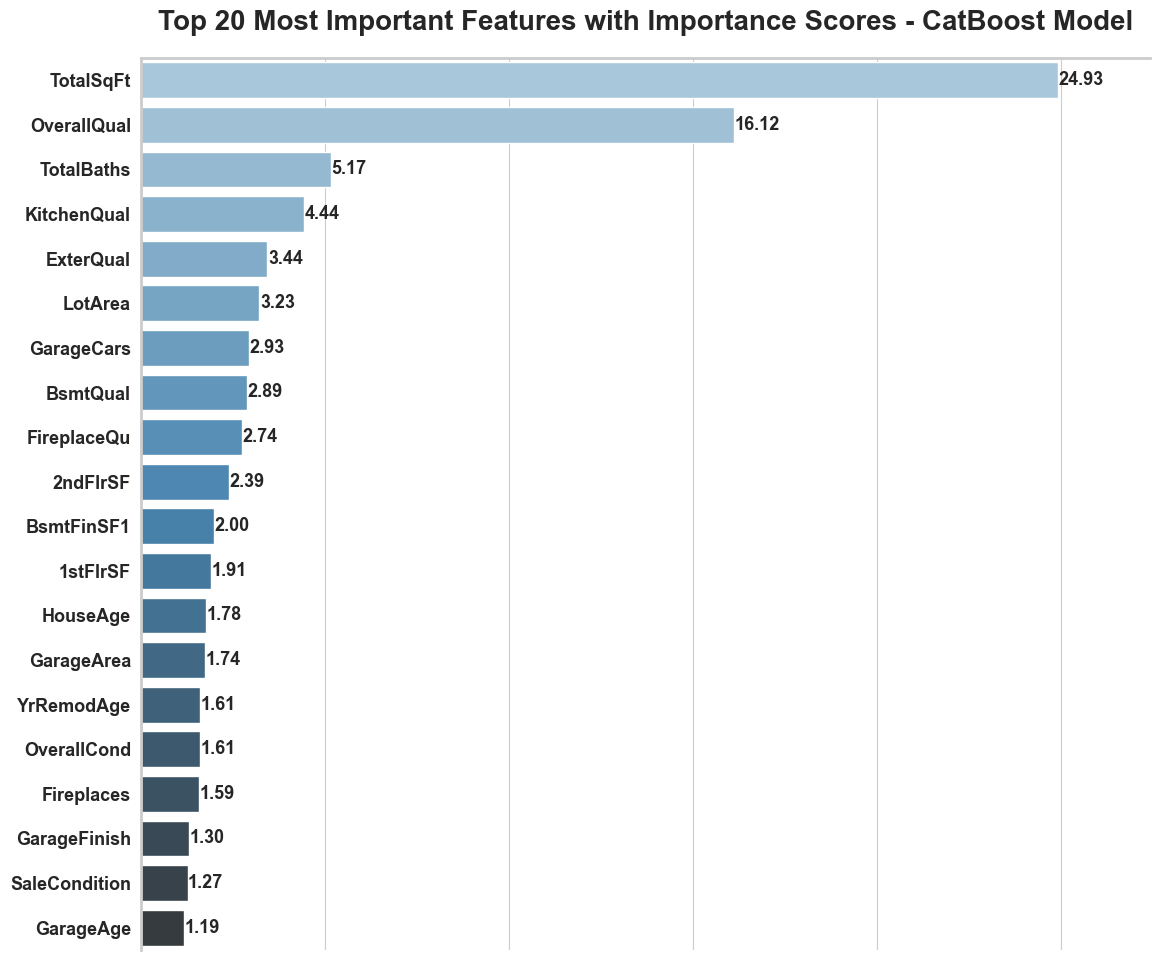

In [189]:
# Set up K-fold cross-validation
kf = KFold(n_splits=5)
feature_importances = []
 
# Iterate over each split
for train_index, test_index in kf.split(data):
    X_ftrain, X_ftest = data.iloc[train_index], data.iloc[test_index]
    y_ftrain, y_ftest = y_train.iloc[train_index], y_train.iloc[test_index]
 
    # Train default CatBoost model
    model = CatBoostRegressor(cat_features=cat_features, random_state=42, verbose=0)
    model.fit(X_ftrain, y_ftrain)
    feature_importances.append(model.get_feature_importance())
 
# Average feature importance across all folds
avg_importance = np.mean(feature_importances, axis=0)
 
# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': data.columns, 'Importance': avg_importance})
 
# Sort and take the top 20 features
top_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Set the style and color palette
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_d", len(top_features))

# Create the plot
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)

# Customize the plot
plt.title('Top 20 Most Important Features with Importance Scores - CatBoost Model', fontweight='bold')
plt.xlabel(None)
plt.ylabel(None)

# Make x-ticks invisible
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Add value labels to the end of each bar
for i, v in enumerate(top_features['Importance']):
    ax.text(v + 0.015, i, f'{v:.2f}', va='center', fontsize=13)

# Extend x-axis by 10% and feature names font size
plt.xlim(0, max(top_features['Importance']) * 1.1)
plt.yticks(fontsize=13)

# Hide all plot spines but keep gridlines
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()


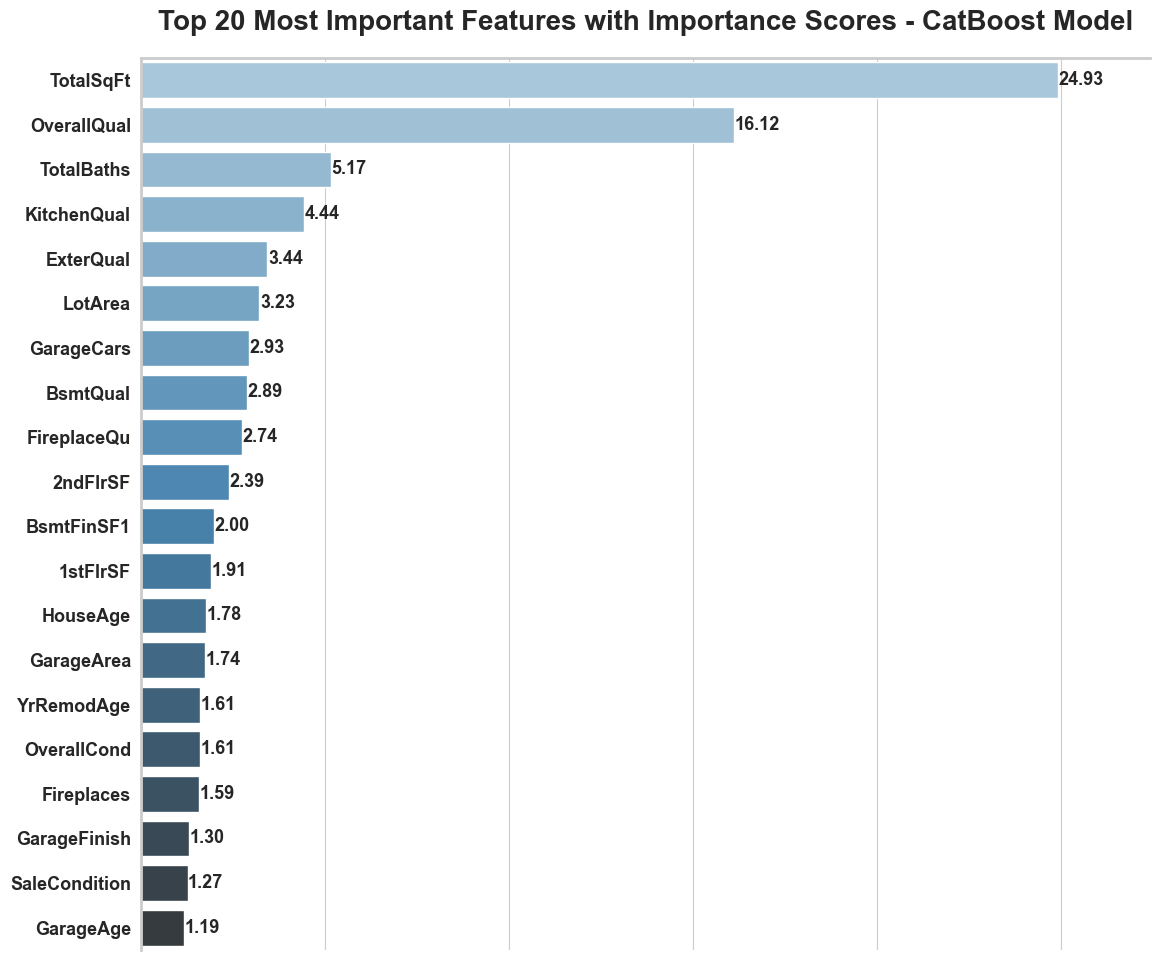

In [224]:
# Set up K-fold cross-validation
kf = KFold(n_splits=5)
feature_importances = []

# Identify and fill NaNs in categorical columns
cat_features = [col for col in data.columns if data[col].dtype == 'object']

# Iterate over each split
for train_index, test_index in kf.split(data):
    X_ftrain, X_ftest = data.iloc[train_index], data.iloc[test_index]
    y_ftrain, y_ftest = y_train.iloc[train_index], y_train.iloc[test_index]
 
    # Train default CatBoost model
    model = CatBoostRegressor(cat_features=cat_features, random_state=42, verbose=0)
    model.fit(X_ftrain, y_ftrain)
    feature_importances.append(model.get_feature_importance())
 
# Average feature importance across all folds
avg_importance = np.mean(feature_importances, axis=0)
 
# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': data.columns, 'Importance': avg_importance})
 
# Sort and take the top 20 features
top_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Set the style and color palette
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_d", len(top_features))

# Create the plot
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)

# Customize the plot
plt.title('Top 20 Most Important Features with Importance Scores - CatBoost Model', fontweight='bold')
plt.xlabel(None)
plt.ylabel(None)

# Make x-ticks invisible
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Add value labels to the end of each bar
for i, v in enumerate(top_features['Importance']):
    ax.text(v + 0.015, i, f'{v:.2f}', va='center', fontsize=13)

# Extend x-axis by 10% and feature names font size
plt.xlim(0, max(top_features['Importance']) * 1.1)
plt.yticks(fontsize=13)

# Hide all plot spines but keep gridlines
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [225]:
# Identify and fill NaNs in categorical columns
cat_features = [col for col in data.columns if data[col].dtype == 'object']

# Define and train the default CatBoost Model
base_model_new = CatBoostRegressor(cat_features = cat_features, random_state = 42, verbose = 0)
base_scores_new = cross_val_score(base_model_new, data, y_train, cv = 5, scoring = 'r2')
print(f"Average r2 score for default CatBoost: {base_scores_new.mean():.4f}")

Average r2 score for default CatBoost: 0.9125


## CatBoost with Selected Features

In [235]:
numerical_features = [
    "TotalSqFt",
    "HouseAge",
    "OverallQual",
    "TotalBaths",
    "TotRmsAbvGrd",
    "GarageCars",
    "YrRemodAge",
    "Fireplaces",
    "LotFrontage",
    "MasVnrArea"
]

categorical_features = ['Neighborhood',
                         'FireplaceQu', 
                         'KitchenQual',
                         'BsmtExposure']
important_features =    numerical_features + categorical_features 

train_model_data = data[important_features]
test_model_data = X_test[important_features]

In [236]:
# Identify and fill NaNs in categorical columns
cat_features = [col for col in train_model_data.columns if train_model_data[col].dtype == 'object']

# Define and train the default CatBoost Model
desired_catboost_model = CatBoostRegressor(cat_features = cat_features, random_state = 42, verbose = 0)
desired_catboost_scores = cross_val_score(desired_catboost_model, train_model_data, y_train, cv = 5, scoring = 'r2')
print(f"Average r2 score for default CatBoost: {desired_catboost_scores.mean():.4f}")

Average r2 score for default CatBoost: 0.9027


In [228]:
def calculate_adjusted_r2(r2_score, n, p):
    """
    Calculate the adjusted R² score.

    Parameters:
    r2_score (float): The R² score.
    n (int): The number of observations.
    p (int): The number of independent variables.

    Returns:
    float: The adjusted R² score.
    """
    adjusted_r2 = 1 - ((1 - r2_score) * (n - 1)) / (n - p - 1)
    return adjusted_r2


In [229]:
print("Adjusted r2_score for desired catboost model:", calculate_adjusted_r2(0.9111, 2580, 15))
print("Adjusted r2_score for base catboost model:", calculate_adjusted_r2(0.9281, 2580, 80))

Adjusted r2_score for desired catboost model: 0.9105799141965679
Adjusted r2_score for base catboost model: 0.9257982793117248


## XGBoost

In [272]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# Preprocessing: Apply scaling to numeric columns
scaler = StandardScaler()
numeric_cols = train_model_data.select_dtypes(include=['float64', 'int64']).columns
# train_model_data[numeric_cols] = scaler.fit_transform(train_model_data[numeric_cols])
# test_model_data[numeric_cols] = scaler.transform(test_model_data[numeric_cols])

# Convert categorical columns to category dtype
cat_feats = ['Neighborhood', 'FireplaceQu', 'KitchenQual', 'BsmtExposure']
for col in cat_feats:
    train_model_data[col] = train_model_data[col].astype('category')
    test_model_data[col] = test_model_data[col].astype('category')


# Create LightGBM datasets for training and validation
train_data = lgb.Dataset(train_model_data, label=y_train, categorical_feature=cat_feats)
test_data = lgb.Dataset(test_model_data, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 11,
    'learning_rate': 0.003,
    'force_col_wise': 'true'
}

# Train with early stopping callback
bst = lgb.train(
    params, 
    train_data, 
    num_boost_round=1000000, 
    valid_sets=[test_data], 
    callbacks=[lgb.early_stopping(stopping_rounds= 500, first_metric_only=True)]
)

# Predict on the test set (use feature columns only)
y_pred = bst.predict(test_model_data, num_iteration=bst.best_iteration)

# Rename result variable to avoid conflict with function name
r2 = r2_score(y_test, y_pred)
mse = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"r2_score: {r2}")
print(f"mse: {mse}")
print(f"mape: {mape}")


[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 14
[LightGBM] [Info] Start training from score 178582.207765
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[3354]	valid_0's l1: 15948.6
Evaluated only: l1
r2_score: 0.920983422355537
mse: 15948.617152422812
mape: 0.08943143715527675


The results you shared indicate an L1 loss of 15,486.4, meaning the model's predictions, on average, differ from actual values by about $15,486. This seems reasonable given your target range of $300K–600K.

The R² score of 0.927 suggests that your model explains about 92.7% of the variance in the target variable, which is a strong fit.

Overall, these metrics indicate that your model is performing quite well, with a relatively low error and a high R², reflecting good predictive power.

In [281]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numerical features
cat_feats = ['Neighborhood', 'FireplaceQu', 'KitchenQual', 'BsmtExposure']
numeric_cols = train_model_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create OneHotEncoder with infrequent category handling
one_hot = OneHotEncoder(handle_unknown='ignore', drop='first', min_frequency = 0.01)

# Create ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', one_hot, cat_feats)
    ]
)

# Apply preprocessing pipeline to train and test data
X_train = preprocessor.fit_transform(train_model_data)
X_test = preprocessor.transform(test_model_data)

# Create LightGBM datasets for training and validation
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 11,
    'learning_rate': 0.003,
    'force_col_wise': True
}

# Train with early stopping
bst = lgb.train(
    params,
    train_data,
    num_boost_round=1000000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds = 500, first_metric_only = True)]
)

# Predict on test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mse = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"r2_score: {r2}")
print(f"mse: {mse}")
print(f"mape: {mape}")

[LightGBM] [Info] Total Bins 892
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 43
[LightGBM] [Info] Start training from score 178582.207765
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[5603]	valid_0's l1: 16038.9
Evaluated only: l1
r2_score: 0.9161646191873412
mse: 16038.878117649603
mape: 0.08877897222559976


In [320]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict
import time
import pandas as pd

data_type_dict = {
    'TotalSqFt': 'float64',
    'HouseAge': 'float64',
    'OverallQual': 'float64',
    'TotalBaths': 'float64',
    'TotRmsAbvGrd': 'float64',
    'GarageCars': 'float64',
    'YrRemodAge': 'float64',
    'Fireplaces': 'float64',
    'LotFrontage': 'float64',
    'MasVnrArea': 'float64',
    'Neighborhood': 'category',
    'FireplaceQu': 'category',
    'KitchenQual': 'category',
    'BsmtExposure': 'category'
}


# Custom MissingValueImputer to handle missing values
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_threshold=0.5):
        self.cat_threshold = cat_threshold
        self.num_imputer = SimpleImputer(strategy = 'median')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        # Handle missing values in categorical columns
        for col in data.select_dtypes(include=['object', 'category']).columns:
            missing_ratio = data[col].isnull().mean() * 100.
            if missing_ratio > self.cat_threshold:
                if pd.api.types.is_categorical_dtype(data[col]):
                    categories = data[col].cat.categories.tolist() + ['Unknown']
                    data[col] = data[col].cat.add_categories(['Unknown'])
                else:
                    data[col] = data[col].astype('category')
                    data[col].cat.add_categories(['Unknown'], inplace=True)
                data[col] = data[col].fillna('Unknown')
            else:
                data[col] = data[col].fillna(data[col].mode()[0])
        # Handle numeric columns with SimpleImputer
        num_cols = data.select_dtypes(include=['number']).columns
        data[num_cols] = self.num_imputer.fit_transform(data[num_cols])
        return data

class DataValidator(BaseEstimator, TransformerMixin):
    def __init__(self, data_types):
        self.data_types = data_types

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column, expected_dtype in self.data_types.items():
            if column in X.columns:
                actual_dtype = X[column].dtype
                
                if actual_dtype != expected_dtype:
                    print(f"Converting column '{column}' from {actual_dtype} to {expected_dtype}.")
                    # Try converting to expected data type
                    try:
                        X[column] = X[column].astype(expected_dtype)
                    except ValueError:
                        raise ValueError(f"Column '{column}' cannot be converted to {expected_dtype}. Current dtype: {actual_dtype}.")
        
        return X
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, desired_features):
        self.desired_features = desired_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create new features here (example: interaction terms, polynomial features)
        # For example, create a new feature as a combination of existing features
        if 'feature1' in X.columns and 'feature2' in X.columns:
            X['feature1_feature2'] = X['feature1'] * X['feature2']  # Example of new feature

        # Ensure that only desired features are returned
        return X[self.desired_features + ['feature1_feature2']]  # Include new feature in output
    
class DataValidator(BaseEstimator, TransformerMixin):
    def __init__(self, data_types):
        self.data_types = data_types

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column, expected_dtype in self.data_types.items():
            if column in X.columns:
                actual_dtype = X[column].dtype
                
                if actual_dtype != expected_dtype:
                    print(f"Converting column '{column}' from {actual_dtype} to {expected_dtype}.")
                    # Try converting to expected data type
                    try:
                        X[column] = X[column].astype(expected_dtype)
                    except ValueError:
                        raise ValueError(f"Column '{column}' cannot be converted to {expected_dtype}. Current dtype: {actual_dtype}.")
        
        return X

    
def load_and_preprocess_data(file_path, preprocessor):
    # Load the data
    data = load_data(file_path)
    
    # Clean column names by removing spaces
    data.columns = list(map(lambda x: ''.join(x.split(' ')), data.columns))

    # create new features
    data['TotalSqFt'] = data['GrLivArea'] + data['TotalBsmtSF']
    data['YrRemodAge'] = data['YrSold'] - data['YearRemod/Add']
    data['HouseAge'] = 2010 - data['YearBuilt']
    data['GarageAge'] = 2010 - data['GarageYrBlt']
    data['TotalBaths'] = data['FullBath'] + 0.5 * data['HalfBath'] + data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath']

    # Desired features
    desired_features = ['TotalSqFt',
                        'HouseAge',
                        'OverallQual',
                        'TotalBaths',
                        'TotRmsAbvGrd',
                        'GarageCars',
                        'YrRemodAge',
                        'Fireplaces',
                        'LotFrontage',
                        'MasVnrArea',
                        'Neighborhood', 
                        'FireplaceQu',
                        'KitchenQual', 
                        'BsmtExposure']

    # make sure these features are in data (except the ones we created)
    
    # Perform data validation
    data = validate_data(data, data_type_dict)

    # Desired features
    
    # Select desired features and transform
    data = FeatureSelector(desired_features).transform(data)
    
    # Preprocess the data
    preprocessed_data = preprocessor.transform(data)
    
    return preprocessed_data

# Example usage
preprocessed_data = load_and_preprocess_data('path/to/data.csv', preprocessor)


# Define categorical and numerical features
cat_feats = ['Neighborhood', 'FireplaceQu', 'KitchenQual', 'BsmtExposure']
numeric_cols = train_model_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', min_frequency=0.1), cat_feats)
    ]
)

# Define the models with default parameters
models = {
    'catboost': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),  # Custom imputer
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(
    iterations = 1000,
    learning_rate = 0.01,  # default learning rate
    depth = 6,  # default depth
    subsample = 1.0,  # no subsampling
    colsample_bylevel = 1.0,  # full sampling per level
    min_data_in_leaf = 1,  # minimum samples in a leaf
    verbose = 0,
    objective = "MAE",
    eval_metric = "MAE",
    early_stopping_rounds = 500))
    ]),
    'lightgbm': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),  # Custom imputer
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor(objective = 'regression_l1', metric = 'mae', num_leaves = 31, learning_rate = 0.1,
        n_estimators = 50,  min_child_samples = 20, min_child_weight = 1e-3, subsample = 1.0, colsample_bytree = 1.0,
        reg_alpha = 0.0, reg_lambda = 0.0
))
    ]),
    'adaboost': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),  # Custom imputer
        ('preprocessor', preprocessor),
        ('regressor', AdaBoostRegressor(n_estimators=100, learning_rate=1.0))
    ]),
    'randomForest': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),  # Custom imputer
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42))
    ]),
    'svm': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),  # Custom imputer
        ('preprocessor', preprocessor),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.1))
    ])
}

# Initialize the scores dictionary using defaultdict
scores = defaultdict(list)

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(train_model_data, y_train)  # Train the model
    end_time = time.time()
    
    # Predict on training and test sets
    y_train_pred = model.predict(train_model_data)
    y_test_pred = model.predict(test_model_data)

    # Store the results
    scores['model'].append(name)
    scores['train_time_sec'].append(end_time - start_time)
    scores['train_r2'].append(r2_score(y_train, y_train_pred))
    scores['test_r2'].append(r2_score(y_test, y_test_pred))
    scores['train_mae'].append(mean_absolute_error(y_train, y_train_pred))
    scores['test_mae'].append(mean_absolute_error(y_test, y_test_pred))

# Convert scores to DataFrame for better visualization
scores_df = pd.DataFrame(scores)
print(scores_df)


The file at c:\Users\anita\Desktop\ames_housing_price_prediction\path/to/data.csv was not found.


AttributeError: 'NoneType' object has no attribute 'columns'

In [294]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd

class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_threshold=0.5):
        self.cat_threshold = cat_threshold
        self.num_imputer = SimpleImputer(strategy = 'median')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()

        # Handle missing values in categorical columns
        for col in data.select_dtypes(include=['object', 'category']).columns:
            missing_ratio = data[col].isnull().mean() * 100.
            if missing_ratio > self.cat_threshold:
                # Set categories first if they are categorical
                if pd.api.types.is_categorical_dtype(data[col]):
                    categories = data[col].cat.categories.tolist() + ['Unknown']
                    data[col] = data[col].cat.add_categories(['Unknown'])
                else:
                    data[col] = data[col].astype('category')
                    data[col].cat.add_categories(['Unknown'], inplace=True)

                data[col] = data[col].fillna('Unknown')
            else:
                data[col] = data[col].fillna(data[col].mode()[0])

        # Handle numeric columns with SimpleImputer
        num_cols = data.select_dtypes(include=['number']).columns
        data[num_cols] = self.num_imputer.fit_transform(data[num_cols])

        return data

# Define your training and test data here
# train_model_data, test_model_data, y_train, y_test = ...

# Define categorical and numerical features
cat_feats = ['Neighborhood', 'FireplaceQu', 'KitchenQual', 'BsmtExposure']
numeric_cols = train_model_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create OneHotEncoder with infrequent category handling
one_hot = OneHotEncoder(handle_unknown='ignore', drop='first', min_frequency=0.01)

# Create ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', one_hot, cat_feats)
    ]
)

# Create AdaBoost pipeline with the custom imputer
pipeline = Pipeline([
    ('imputer', MissingValueImputer(cat_threshold = 0.5)),  # Custom imputer to handle missing values
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor(n_estimators = 100, learning_rate = 1.0))
])

# Fit the model
pipeline.fit(train_model_data, y_train)

# Predict on test set
y_pred = pipeline.predict(test_model_data)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mse = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"r2_score: {r2}")
print(f"mse: {mse}")
print(f"mape: {mape}")


r2_score: 0.8507593017694928
mse: 23799.415194328194
mape: 0.15139658571555445


In [295]:
# Fit the preprocessor on training data and transform both train and test sets
X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(train_model_data)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(test_model_data)

# Convert to DataFrame for better visualization with column names
import pandas as pd

# Get the feature names after transformation
ohe_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_feats)
num_columns = numeric_cols

# Concatenate the numeric and encoded categorical columns
transformed_columns = list(num_columns) + list(ohe_columns)

# Create DataFrame for transformed train and test data
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns)

# Display the transformed data with columns
print(X_train_transformed_df.head())
print(X_test_transformed_df.head())


   TotalSqFt  HouseAge  OverallQual  TotalBaths  TotRmsAbvGrd  GarageCars  \
0  -0.100204 -0.181084     0.673941   -0.251545     -0.261706    0.339058   
1   0.749261  0.115603    -0.766750    0.981971      0.377959    0.339058   
2  -1.646506  0.280430    -1.487095   -0.251545     -0.261706    0.339058   
3  -1.876700  0.708978    -1.487095   -0.251545     -0.261706    0.339058   
4  -0.299122  1.664971    -1.487095   -0.251545      1.017625   -2.341388   

   YrRemodAge  Fireplaces  LotFrontage  MasVnrArea  ...  FireplaceQu_Po  \
0    0.439320    0.614268     0.485756    0.531409  ...             0.0   
1    0.872439   -0.917482    -0.008229   -0.569155  ...             0.0   
2    1.016812   -0.917482     0.036679   -0.569155  ...             0.0   
3    1.690554   -0.917482    -0.412398   -0.569155  ...             0.0   
4    1.690554   -0.917482    -0.277675   -0.569155  ...             0.0   

   FireplaceQu_TA  FireplaceQu_Unknown  KitchenQual_Fa  KitchenQual_Gd  \
0           

In [352]:
import time
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin

class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_threshold=0.5):
        self.cat_threshold = cat_threshold
        self.num_imputer = SimpleImputer(strategy='median')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)

        for col in data.select_dtypes(include=['object', 'category']).columns:
            missing_ratio = data[col].isnull().mean()
            if missing_ratio > self.cat_threshold:
                data[col] = data[col].astype('category').cat.add_categories(['Unknown']).fillna('Unknown')
            else:
                data[col] = data[col].fillna(data[col].mode()[0])

        num_cols = data.select_dtypes(include=['number']).columns
        data[num_cols] = self.num_imputer.fit_transform(data[num_cols])
        return data

class DataValidator(BaseEstimator, TransformerMixin):
    def __init__(self, data_types, message=False):
        self.data_types = data_types
        self.message = message

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        for column, expected_dtype in self.data_types.items():
            if column in X.columns:
                actual_dtype = X[column].dtype
                if expected_dtype == 'number' and not pd.api.types.is_numeric_dtype(actual_dtype):
                    if self.message:
                        print(f"Converting column '{column}' to numeric.")
                    X[column] = pd.to_numeric(X[column], errors='coerce')
                elif expected_dtype == 'category' and not pd.api.types.is_categorical_dtype(actual_dtype):
                    if self.message:
                        print(f"Converting column '{column}' to category.")
                    X[column] = X[column].astype('category')
        return X

class FeatureEngineer:
    def __init__(self, data_type_dict):
        self.data_type_dict = data_type_dict

    def create_features(self, data):
        used_features = ['GrLivArea', 'TotalBsmtSF', 'YrSold', 'YearRemodAdd', 
                         'YearBuilt', 'GarageYrBlt', 'FullBath', 
                         'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
        
        # Check if all used features are in data columns
        missing_features = [feature for feature in used_features if feature not in data.columns]
        if missing_features:
            print(f"Warning: The following used features are missing from the data: {missing_features}")
        
        # Create new features
        data['TotalSqFt'] = data['GrLivArea'].fillna(0) + data['TotalBsmtSF'].fillna(0)
        data['YrRemodAge'] = data['YrSold'].fillna(0) - data['YearRemodAdd'].fillna(0)
        data['HouseAge'] = 2010 - data['YearBuilt'].fillna(0)
        data['GarageAge'] = 2010 - data['GarageYrBlt'].fillna(0)
        data['TotalBaths'] = (data['FullBath'].fillna(0) + 
                              0.5 * data['HalfBath'].fillna(0) + 
                              data['BsmtFullBath'].fillna(0) + 
                              0.5 * data['BsmtHalfBath'].fillna(0))

        desired_features = set(self.data_type_dict.keys()).intersection(data.columns) - set(used_features)
        return data[list(desired_features)]


class ModelTrainer:
    def __init__(self, models):
        self.models = models
        self.scores = defaultdict(list)

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        for name, model in self.models.items():
            start_time = time.time()
            model.fit(X_train, y_train)
            end_time = time.time()
            self.evaluate_model(name, model, X_train, y_train, X_test, y_test, end_time - start_time)

    def evaluate_model(self, name, model, X_train, y_train, X_test, y_test, train_time):
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        self.scores['model'].append(name)
        self.scores['train_time_sec'].append(train_time)
        self.scores['train_r2'].append(r2_score(y_train, y_train_pred))
        self.scores['test_r2'].append(r2_score(y_test, y_test_pred))
        self.scores['train_mae'].append(mean_absolute_error(y_train, y_train_pred))
        self.scores['test_mae'].append(mean_absolute_error(y_test, y_test_pred))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.replace(' ', '').str.replace(r'[^A-Za-z0-9_]', '', regex=True)
    return data

class DataPipeline:
    def __init__(self, file_path, target, preprocessor, feature_engineer):
        self.file_path = file_path
        self.target = target
        self.preprocessor = preprocessor
        self.feature_engineer = feature_engineer

    def load_and_preprocess_data(self):
        data = load_data(self.file_path)

        # Validate and transform the data types
        data = DataValidator(data_type_dict).fit_transform(data)
        
        # Create features
        data = self.feature_engineer.create_features(data)

        desired_features = list(self.feature_engineer.data_type_dict.keys())
        if self.target in data.columns:
            y = data[self.target]
            data = data[desired_features]
            return self.preprocessor.fit_transform(data), y
        else:
            return self.preprocessor.fit_transform(data), None

# Define data types
data_type_dict = {
    'GrLivArea': 'number',
    'YearBuilt': 'number',
    'YrSold': 'number',
    'GarageYrBlt': 'number',
    'TotalBsmtSF': 'number',
    'TotalSqFt': 'number',
    'HouseAge': 'number',
    'OverallQual': 'number',
    'TotalBaths': 'number',
    'TotRmsAbvGrd': 'number',
    'GarageCars': 'number',
    'YrRemodAge': 'number',
    'Fireplaces': 'number',
    'LotFrontage': 'number',
    'MasVnrArea': 'number',
    'Neighborhood': 'category',
    'FireplaceQu': 'category',
    'KitchenQual': 'category',
    'BsmtExposure': 'category',
    'SalePrice': 'number',  # Target column
    'FullBath': 'number',
    'HalfBath': 'number',
    'BsmtFullBath': 'number',
    'BsmtHalfBath': 'number'
}

# Create ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in data_type_dict if data_type_dict[col] == 'number']),
        ('cat', OneHotEncoder(drop = 'first', min_frequency = 0.02, handle_unknown= 'infrequent_if_exist'), 
         ['Neighborhood', 'FireplaceQu', 'KitchenQual', 'BsmtExposure'])
    ])

# Define models
models = {
    'catboost': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(
            iterations=1000,
            learning_rate=0.01,
            depth=6,
            subsample=1.0,
            colsample_bylevel=1.0,
            min_data_in_leaf=1,
            verbose=0,
            objective="MAE",
            eval_metric="MAE",
            early_stopping_rounds=500))
    ]),
    'lightgbm': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor(objective='regression_l1', metric='mae', num_leaves=31,
                                     learning_rate=0.1, n_estimators=50, min_child_samples=20, 
                                     min_child_weight=1e-3, subsample=1.0, colsample_bytree=1.0,
                                     reg_alpha=0.0, reg_lambda=0.0))
    ]),
    'adaboost': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),
        ('preprocessor', preprocessor),
        ('regressor', AdaBoostRegressor(n_estimators=100, learning_rate=1.0))
    ]),
    'randomForest': Pipeline([
        ('imputer', MissingValueImputer(cat_threshold=0.5)),
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42))
    ])
}

# Load and preprocess data
target = 'SalePrice'
train_pipeline = DataPipeline('./data/raw_data/train.csv', target, preprocessor, FeatureEngineer(data_type_dict))
train_model_data, y_train = train_pipeline.load_and_preprocess_data()

test_pipeline = DataPipeline('./data/raw_data/test.csv', target, preprocessor, FeatureEngineer(data_type_dict))
test_model_data, y_test = test_pipeline.load_and_preprocess_data()

# Initialize ModelTrainer and train the models
trainer = ModelTrainer(models)
# Continue training the models
try:
    trainer.train_and_evaluate(train_model_data, y_train, test_model_data, y_test)
except Exception as e:
    print(f"An error occurred during model training: {e}")

# Print the scores
for key, value in trainer.scores.items():
    print(f"{key}: {value}")

KeyError: "['GrLivArea', 'YearBuilt', 'YrSold', 'GarageYrBlt', 'TotalBsmtSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'] not in index"

In [344]:
# Assuming you have classes like DataLoader, Preprocessor, FeatureEngineer

# Test DataLoader
data_loader = DataLoader('./data/raw_data/train.csv')
data = data_loader.load_data()
print("Loaded Data Shape:", data.shape)

# Test Preprocessor
preprocessor = Preprocessor()
transformed_data = preprocessor.fit_transform(data)
print("Transformed Data Shape:", transformed_data.shape)

# Test Feature Engineer
feature_engineer = FeatureEngineer(data_type_dict)
features = feature_engineer.create_features(data)
print("Generated Features:", features.head())


Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish'